In [ ]:
import numpy as np
import pandas as pd
import os
import librosa
from scipy.signal import convolve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import soundfile as sf
from IPython.display import Audio, display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Configurations for Sine-circle  Map and model
class Config:
    K_chaotic = 2.3
    K_non_chaotic = 2.1
    K_C_T = 2.4
    K_NC_T = 2.0
    omega = 0.606661
    x0 = np.random.rand()
    length = 5000

    # Model parameters
    input_shape = (10000, 1)
    num_classes = 2  # Binary classification
    learning_rate = 1e-4
    l2_lambda = 0.001

    # File paths
    data_file_path = 'truncated_fake_or_real_audio5.npz'
    best_model_path = 'best model_fake_or_real_sine circle.keras'
    best_model_path_1 = 'Shallownet_fake_or_real.keras'
    best_model_path_2 = 'MLP_fake_or_real.keras'
    best_model_path_3 = 'FCN_fake_or_real.keras'
    best_model_path_4 = 'Resnet_fake_or_real.keras'
    best_model_path_5 = 'LKCNN_fake_or_real.keras'
    best_model_path_new = 'best model_fake_or_real_sine circle_new.keras'
    best_model_path_r = 'best_model_resnet2.keras'
    best_model_path_s = 'best_model_ssdnet1d.keras'
    best_model_path_i = 'best_model_incnet1d.keras'
    best_model_path_m = 'best_model_incnet1d_m.keras'
    best_model_path_m2 = 'best_model_incnet1d_m2.keras'
    best_model_path_rtssd = 'best_model_fake_or_real_restssd_sinecircle.keras'

In [ ]:
# Loading data
metadata = pd.read_csv('/content/drive/MyDrive/fake_or_real/metadata.csv')
#metadata = pd.read_csv('/content/drive/MyDrive/fake_or_real/metadata audio5 - Sheet1.csv')
#metadata = pd.read_csv('/content/drive/MyDrive/IITR/Fake_or_real/Audio/metadata.csv')
le = LabelEncoder()
metadata['label'] = le.fit_transform(metadata['label'])

In [ ]:
def load_audio_file(file_path):
    try:
        audio, sr = librosa.load(file_path, sr=22050)
        return audio
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None
    except Exception as e:
        print(f"An error occurred while loading {file_path}: {e}")
        return None

In [ ]:
# Function to load audio files and labels with detailed debug information
def load_fake_or_real(data_path, metadata):
    audio_files = []
    labels = []
    for index, row in metadata.iterrows():
        # Directly access the filename without fold subdirectories
        file_path = os.path.join(data_path, row['filename'])
        audio = load_audio_file(file_path)
        audio_files.append(audio)
        labels.append(row['label'])
    return audio_files, np.array(labels)

In [ ]:
# Load audio files and labels
#audio_files, labels = load_fake_or_real('/content/drive/MyDrive/fake_or_real/audio 5', metadata)
audio_files, labels = load_fake_or_real('/content/drive/MyDrive/fake_or_real/audio', metadata)

In [ ]:
# Truncating audio files
min_length = min(len(audio) for audio in audio_files)
print(min_length)

16308


In [ ]:
audio_files_truncated = [audio[:10000] for audio in audio_files]

In [ ]:
# Converting to numpy arrays
audio_files_array = np.array(audio_files_truncated)
labels_array = np.array(labels)

In [ ]:
# Print the shape of the truncated audio files array and labels array
print(f'Shape of truncated audio files array: {audio_files_array.shape}')
print(f'Shape of labels array: {labels_array.shape}')

Shape of truncated audio files array: (8000, 10000)
Shape of labels array: (8000,)


In [ ]:
# Saving numpy arrays to a file
np.savez(Config.data_file_path, audio_files=audio_files_array, labels=labels_array)

In [ ]:
# Loading arrays
loaded_data = np.load(Config.data_file_path)
audio_files_array = loaded_data['audio_files']
labels_array = loaded_data['labels']

In [ ]:
labels = labels_array

In [ ]:
def sine_circle_map(omega, K, x0, n):
    x = np.zeros(n)
    x[0] = x0
    for i in range(1, n):
        x[i] = (x[i-1] + omega - (K / (2 * np.pi)) * np.sin(2 * np.pi * x[i-1])) % 1
    return x

In [ ]:
print(f'K_chaotic = {Config.K_chaotic}')
print(f'K_non_chaotic = {Config.K_non_chaotic}')
print(f'x0 = {Config.x0}')
print(f'length = {Config.length}')

K_chaotic = 2.3
K_non_chaotic = 2.1
x0 = 0.924045506579057
length = 5000


In [ ]:
#Add
print(f'K_chaotic_T = {Config.K_C_T}')
print(f'K_non_chaotic_T = {Config.K_NC_T}')

K_chaotic_T = 2.4
K_non_chaotic_T = 2.0


In [ ]:
chaotic_series = sine_circle_map(Config.omega, Config.K_chaotic, Config.x0, Config.length)
non_chaotic_series = sine_circle_map(Config.omega, Config.K_non_chaotic, Config.x0, Config.length)

In [ ]:
#Add
chaotic_series_T = sine_circle_map(Config.omega, Config.K_C_T, Config.x0, Config.length)
non_chaotic_series_T = sine_circle_map(Config.omega, Config.K_NC_T, Config.x0, Config.length)

In [ ]:
print(chaotic_series)

[0.92404551 0.69884568 0.6528174  ... 0.64618578 0.54375158 0.24977858]


In [ ]:
print(non_chaotic_series)

[0.92404551 0.68422488 0.59697268 ... 0.54613583 0.24833089 0.52078489]


In [ ]:
#Add
print(chaotic_series_T)
print(non_chaotic_series_T)

[0.92404551 0.70615608 0.68038665 ... 0.94891659 0.67608356 0.6242567 ]
[0.92404551 0.67691448 0.56890942 ... 0.16587868 0.49766659 0.09966095]


In [ ]:
MAX_chaotic = 0.9993632086366939
chaotic_series_normalized = chaotic_series / MAX_chaotic
print(chaotic_series_normalized)

[0.92463431 0.69929098 0.65323338 ... 0.64659752 0.54409805 0.24993773]


In [ ]:
MAX_non_chaotic = 0.9993375202604273
non_chaotic_series_normalized = non_chaotic_series / MAX_non_chaotic
print(non_chaotic_series_normalized)

[0.92465807 0.68467847 0.59736842 ... 0.54649788 0.24849551 0.52113013]


In [ ]:
#Add
#MAX_chaotic = 0.9993632086366939
MAX_chaotic = 0.9982397807380526
chaotic_series_normalized_T = chaotic_series_T / MAX_chaotic
print(chaotic_series_normalized_T)

[0.9256749  0.70740126 0.68158639 ... 0.95058984 0.67727571 0.62535747]


In [ ]:
#Add
#MAX_non_chaotic = 0.9993375202604273
MAX_non_chaotic = 0.9921288494162146
non_chaotic_series_normalized_T = non_chaotic_series_T / MAX_non_chaotic
print(non_chaotic_series_normalized_T)

[0.93137651 0.68228485 0.57342292 ... 0.16719469 0.50161488 0.10045162]


In [ ]:
# Convolution functions
def convolve_with_series(audio, series):
    return convolve(audio, series, mode='same')

In [ ]:
# Convolve each audio sample with chaotic and non-chaotic time series
audio_files_chaotic = [convolve_with_series(audio, chaotic_series_normalized) for audio in audio_files_array]
audio_files_chaotic = np.array(audio_files_chaotic)

In [ ]:
audio_files_non_chaotic = [convolve_with_series(audio, non_chaotic_series_normalized) for audio in audio_files_array]
audio_files_non_chaotic = np.array(audio_files_non_chaotic)

In [ ]:
#Add
# Convolve each audio sample with chaotic and non-chaotic time series
audio_files_chaotic_T = [convolve_with_series(audio, chaotic_series_normalized_T) for audio in audio_files_array]
audio_files_chaotic_T = np.array(audio_files_chaotic_T)

In [ ]:
#Add
audio_files_non_chaotic_T = [convolve_with_series(audio, non_chaotic_series_normalized_T) for audio in audio_files_array]
audio_files_non_chaotic_T = np.array(audio_files_non_chaotic_T)

In [ ]:
def normalize_audio_standard_scaled(audio):
    mean = np.mean(audio)
    std = np.std(audio)
    print(f'Mean: {mean}, Standard Deviation: {std}')
    if(std!=0):
      audio = (audio - mean) / std
    else:
      audio = audio
    min_val = np.min(audio)
    max_val = np.max(audio)
    scaled_audio = 2 * (audio - min_val) / (max_val - min_val) - 1
    print(f'Min Value: {min_val}, Max Value: {max_val}')
    print(f'Scaled Min Value: {np.min(scaled_audio)}, Scaled Max Value: {np.max(scaled_audio)}')
    return scaled_audio

In [ ]:
audio_files_chaotic_normalized = np.array([normalize_audio_standard_scaled(audio) for audio in audio_files_chaotic])
audio_files_non_chaotic_normalized = np.array([normalize_audio_standard_scaled(audio) for audio in audio_files_non_chaotic])

Mean: 0.016593249423198522, Standard Deviation: 1.4812419247638404
Min Value: -3.4911739692370993, Max Value: 3.54412528116473
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: -0.7450879660370918, Standard Deviation: 2.3621595150687127
Min Value: -3.9591456743851605, Max Value: 3.993558765368238
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: 6.67763064421441, Standard Deviation: 3.763467952947866
Min Value: -2.485983042674895, Max Value: 4.003758390279306
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: -0.015433582180674943, Standard Deviation: 2.471272904693168
Min Value: -4.215377133094616, Max Value: 3.68422594828557
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: -2.813595901540186, Standard Deviation: 2.670928784086694
Min Value: -3.6033398048544503, Max Value: 3.5939065175657827
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: -0.5353325660870822, Standard Deviation: 2.8041801516732026
Min Value: -1.4098167695099257, Max Value: 2.9454736660366927
Scaled Min Val

<ipython-input-32-a8798967b480>:11: RuntimeWarning: invalid value encountered in divide
  scaled_audio = 2 * (audio - min_val) / (max_val - min_val) - 1


Streaming output truncated to the last 5000 lines.
Min Value: -3.1215662359240595, Max Value: 3.77325085991586
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: 0.028625110114397, Standard Deviation: 0.33747449838473764
Min Value: -3.051245158370021, Max Value: 4.519766805100518
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: -0.203583209855029, Standard Deviation: 2.920426499820903
Min Value: -2.2779624292808207, Max Value: 1.6559789913909864
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: -0.40417915080149897, Standard Deviation: 0.6492570532934765
Min Value: -5.340884405840007, Max Value: 2.597507957354498
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: -0.06262308902442819, Standard Deviation: 0.516015193100815
Min Value: -4.512812190091197, Max Value: 4.050506664583405
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: 0.027594014209933754, Standard Deviation: 0.44637697329987
Min Value: -4.010848707125385, Max Value: 4.777829602566573
Scaled Min Value: -1.0, Scaled

In [ ]:
#Add
audio_files_chaotic_normalized_T = np.array([normalize_audio_standard_scaled(audio) for audio in audio_files_chaotic_T])
audio_files_non_chaotic_normalized_T = np.array([normalize_audio_standard_scaled(audio) for audio in audio_files_non_chaotic_T])

Mean: 0.019921468064807255, Standard Deviation: 1.3706416313083816
Min Value: -3.7001914153173443, Max Value: 3.708167787089097
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: -0.8482894067686683, Standard Deviation: 3.076446352343749
Min Value: -2.6404773487004185, Max Value: 2.9726673037120905
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: 7.491625353192309, Standard Deviation: 4.176647891104995
Min Value: -2.737018235630617, Max Value: 3.270456864356226
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: -0.01737752153634049, Standard Deviation: 3.0366689777902445
Min Value: -3.930047613018157, Max Value: 3.5860199806627193
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: -3.160620828399725, Standard Deviation: 2.946709999601465
Min Value: -3.2836087369883495, Max Value: 3.4115853670667433
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: -0.5998390024947313, Standard Deviation: 3.1360308727758746
Min Value: -1.3749071615473305, Max Value: 2.7255619111653058
Scaled Min

<ipython-input-32-a8798967b480>:11: RuntimeWarning: invalid value encountered in divide
  scaled_audio = 2 * (audio - min_val) / (max_val - min_val) - 1


Streaming output truncated to the last 5000 lines.
Min Value: -3.2996189637829305, Max Value: 3.6732778324758004
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: 0.027322880214105113, Standard Deviation: 0.2999292645439766
Min Value: -2.538527713502692, Max Value: 4.195423456912685
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: -0.19474981448655562, Standard Deviation: 2.790855742987006
Min Value: -2.335582941711274, Max Value: 1.6613953261307335
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: -0.38605565561565097, Standard Deviation: 0.6474144260026593
Min Value: -5.568179354412811, Max Value: 2.7434533017402662
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: -0.05982066670806553, Standard Deviation: 0.47193368713759903
Min Value: -3.963782630955207, Max Value: 4.095883129358798
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: 0.02629733145497845, Standard Deviation: 0.44405079897460065
Min Value: -3.726946056700908, Max Value: 4.559712309073812
Scaled Min Value: -1

In [ ]:
# Function to plot the waveform of an audio file
def plot_waveform(audio, sr, title):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(audio, sr=sr)
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

In [ ]:
# Function to load and return audio as numpy array
def load_audio(file_path, sr=22050):
    audio, sr = librosa.load(file_path, sr=sr)
    return audio, sr

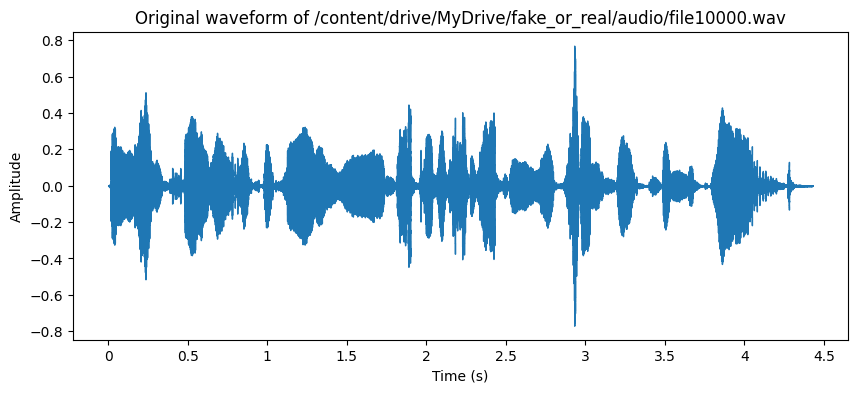

In [ ]:
import soundfile as sf
import librosa
import librosa.display
import matplotlib.pyplot as plt
# List of audio file paths
audio_files = [ '/content/drive/MyDrive/fake_or_real/audio/file10000.wav',
                '/content/drive/MyDrive/fake_or_real/audio/file10060.wav',
                '/content/drive/MyDrive/fake_or_real/audio/file1288.wav',
                '/content/drive/MyDrive/fake_or_real/audio/file1524.wav',
                '/content/drive/MyDrive/fake_or_real/audio/file1811.wav',
                '/content/drive/MyDrive/fake_or_real/audio/file1849.wav',
                '/content/drive/MyDrive/fake_or_real/audio/file1683.wav',
                '/content/drive/MyDrive/fake_or_real/audio/file1675.wav'
              ]
#Then load the audio file
file_path = audio_files[0]
audio, sr = load_audio(file_path)
plot_waveform(audio, sr, f'Original waveform of {file_path}')

Mean: 7.156369520089356e-06, Standard Deviation: 0.0750344768166542
Min Value: -10.206178665161133, Max Value: 10.25886058807373
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: -6.568215407768908, Standard Deviation: 1.7435069245963397
Min Value: -4.8966527649553475, Max Value: 5.371617770509593
Scaled Min Value: -1.0, Scaled Max Value: 1.0


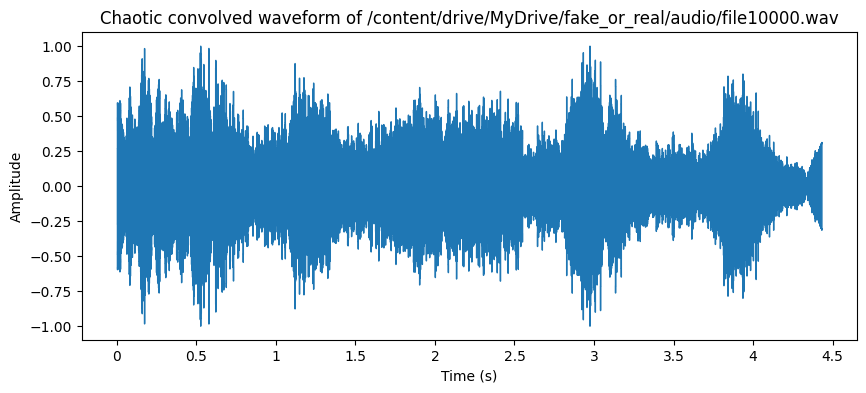

Mean: -4.318738904017565, Standard Deviation: 0.6346536109647187
Min Value: -4.775896353660764, Max Value: 6.4549652199329675
Scaled Min Value: -1.0, Scaled Max Value: 1.0


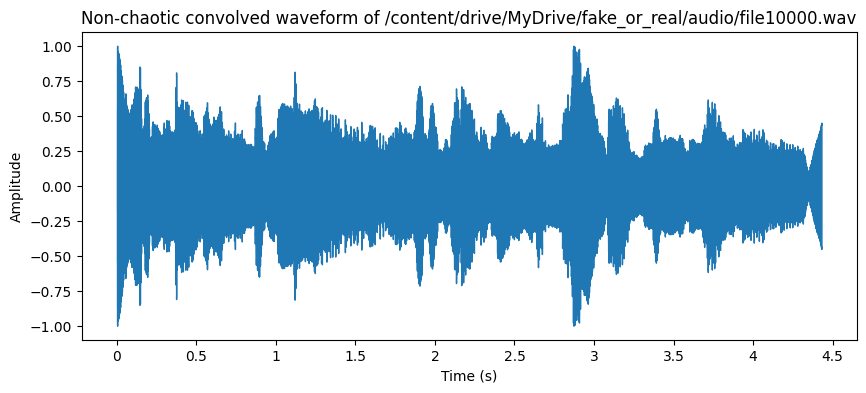

In [ ]:
# Convolve with chaotic series and play/plot the result
audio_normalized = normalize_audio_standard_scaled(audio)

audio_chaotic = convolve_with_series(audio_normalized, chaotic_series_normalized)
audio_chaotic_scaled = normalize_audio_standard_scaled(audio_chaotic)
plot_waveform(audio_chaotic_scaled, sr, f'Chaotic convolved waveform of {file_path}')

# Convolve with non-chaotic series and play/plot the result

audio_non_chaotic = convolve_with_series(audio_normalized, non_chaotic_series_normalized)
audio_non_chaotic_scaled = normalize_audio_standard_scaled(audio_non_chaotic)
plot_waveform(audio_non_chaotic_scaled, sr, f'Non-chaotic convolved waveform of {file_path}')

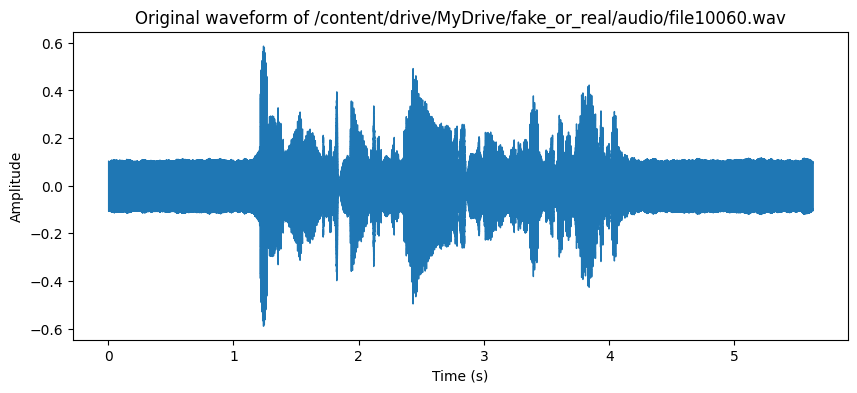

Mean: -0.10515294224023819, Standard Deviation: 0.05009184777736664
Min Value: -9.639562606811523, Max Value: 6.245936393737793
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: 546.5665813234558, Standard Deviation: 33.780301732014415
Min Value: -8.069828893094058, Max Value: 2.2428587135959805
Scaled Min Value: -1.0, Scaled Max Value: 1.0


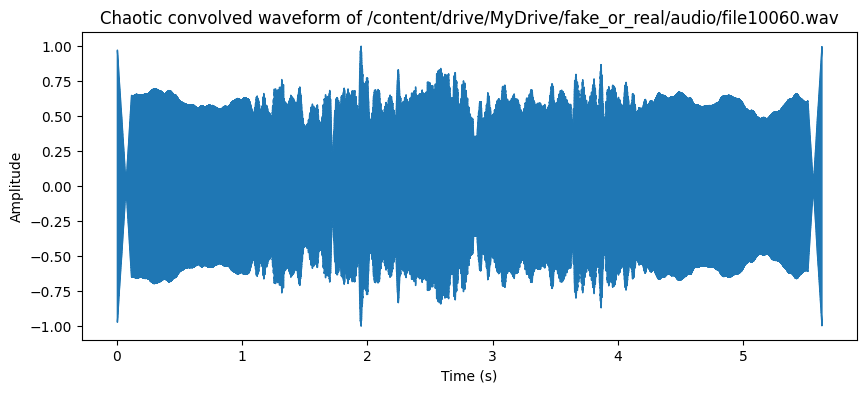

Mean: 359.38696804755386, Standard Deviation: 22.29661833073746
Min Value: -8.095785299186165, Max Value: 2.227834872658597
Scaled Min Value: -1.0, Scaled Max Value: 1.0


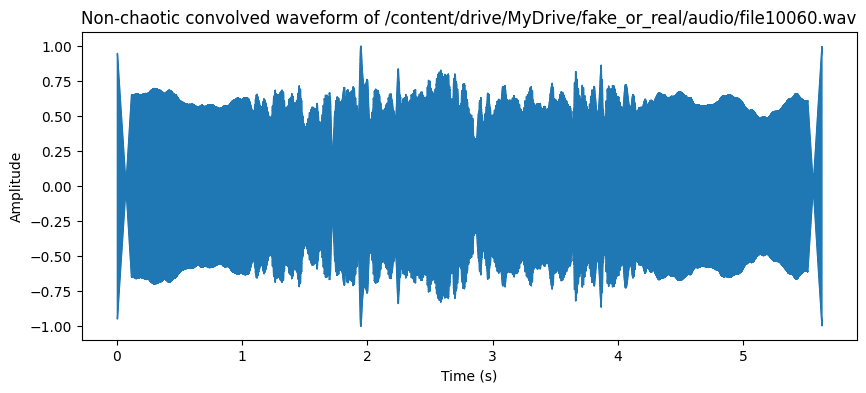

In [ ]:
#Then load the audio file
file_path = audio_files[1]
audio, sr = load_audio(file_path)
plot_waveform(audio, sr, f'Original waveform of {file_path}')

# Convolve with chaotic series and play/plot the result
audio_normalized = normalize_audio_standard_scaled(audio)

audio_chaotic = convolve_with_series(audio_normalized, chaotic_series_normalized)
audio_chaotic_scaled = normalize_audio_standard_scaled(audio_chaotic)
plot_waveform(audio_chaotic_scaled, sr, f'Chaotic convolved waveform of {file_path}')

# Convolve with non-chaotic series and play/plot the result

audio_non_chaotic = convolve_with_series(audio_normalized, non_chaotic_series_normalized)
audio_non_chaotic_scaled = normalize_audio_standard_scaled(audio_non_chaotic)
plot_waveform(audio_non_chaotic_scaled, sr, f'Non-chaotic convolved waveform of {file_path}')

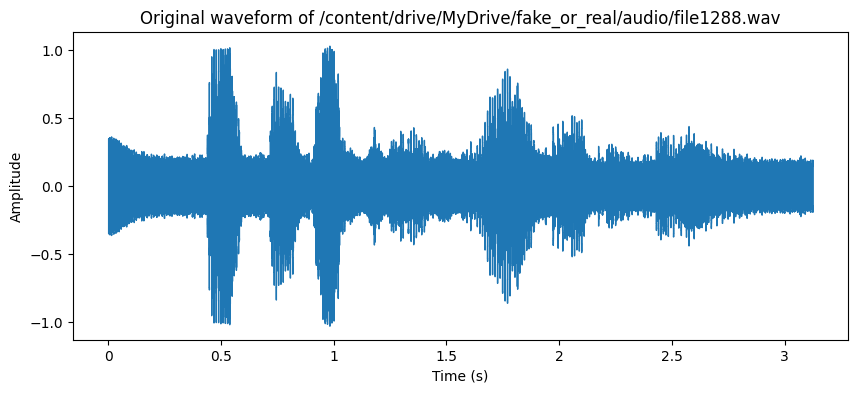

Mean: -0.15422062575817108, Standard Deviation: 0.10780365020036697
Min Value: -8.006406784057617, Max Value: 10.971303939819336
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: -393.63309239134776, Standard Deviation: 41.61950580936723
Min Value: -4.646772647091871, Max Value: 4.841324546215089
Scaled Min Value: -1.0, Scaled Max Value: 1.0


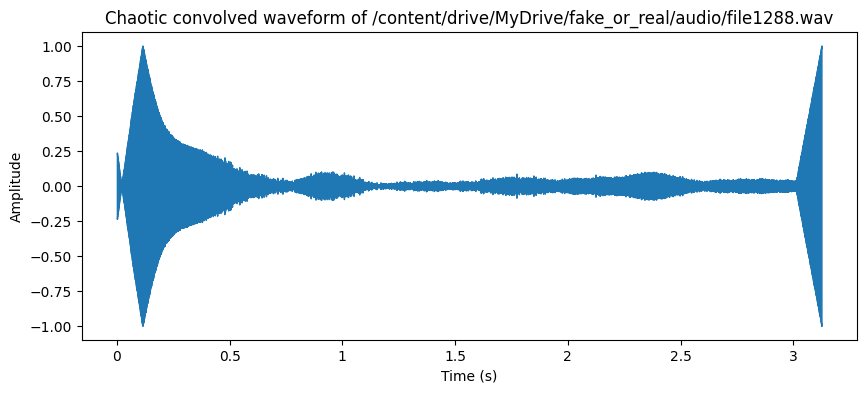

Mean: -258.7811175081628, Standard Deviation: 27.364179641621718
Min Value: -4.616424315655513, Max Value: 4.864953159204525
Scaled Min Value: -1.0, Scaled Max Value: 1.0


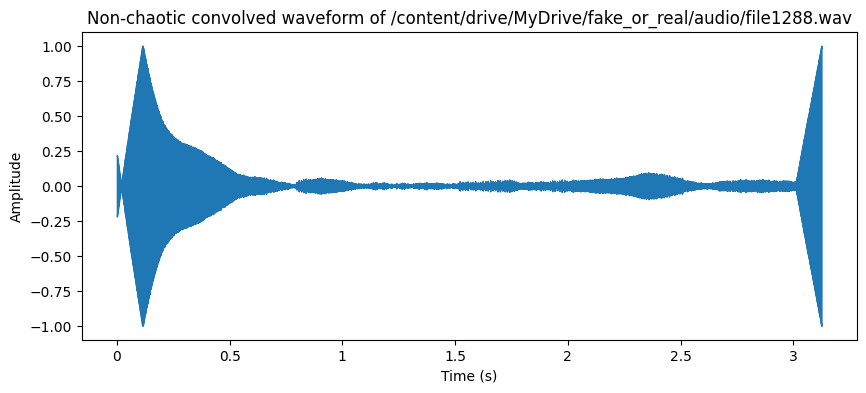

In [ ]:
#Then load the audio file
file_path = audio_files[2]
audio, sr = load_audio(file_path)
plot_waveform(audio, sr, f'Original waveform of {file_path}')

# Convolve with chaotic series and play/plot the result
audio_normalized = normalize_audio_standard_scaled(audio)

audio_chaotic = convolve_with_series(audio_normalized, chaotic_series_normalized)
audio_chaotic_scaled = normalize_audio_standard_scaled(audio_chaotic)
plot_waveform(audio_chaotic_scaled, sr, f'Chaotic convolved waveform of {file_path}')

# Convolve with non-chaotic series and play/plot the result

audio_non_chaotic = convolve_with_series(audio_normalized, non_chaotic_series_normalized)
audio_non_chaotic_scaled = normalize_audio_standard_scaled(audio_non_chaotic)
plot_waveform(audio_non_chaotic_scaled, sr, f'Non-chaotic convolved waveform of {file_path}')

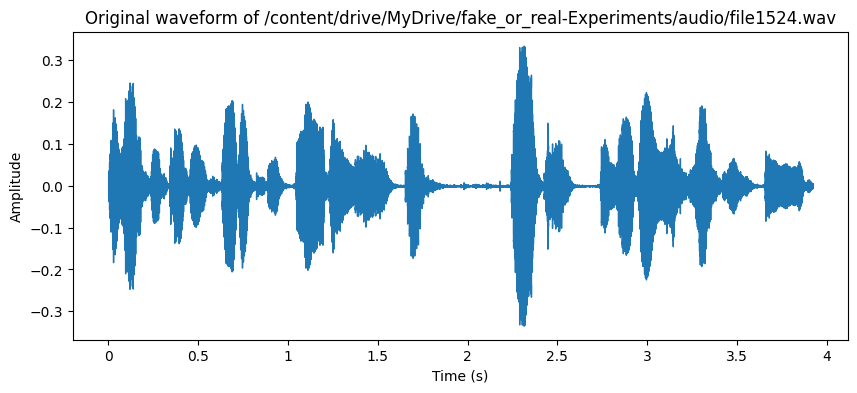

Mean: -4.1470499127171934e-05, Standard Deviation: 0.04003416746854782
Min Value: -6.986649513244629, Max Value: 8.350482940673828
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: -227.57805356074047, Standard Deviation: 15.986756359170828
Min Value: -1.4232655067329527, Max Value: 7.118531179548397
Scaled Min Value: -1.0, Scaled Max Value: 1.0


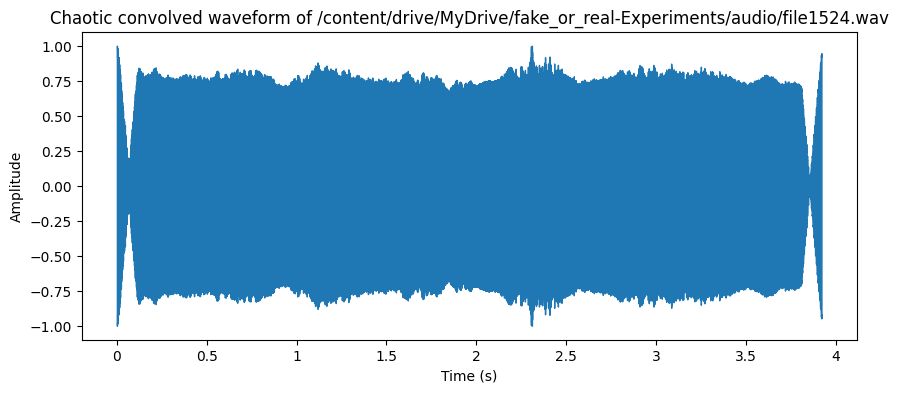

Mean: -148.96907773785261, Standard Deviation: 10.39751379258258
Min Value: -0.6157440972053755, Max Value: 7.078940816400576
Scaled Min Value: -1.0, Scaled Max Value: 1.0


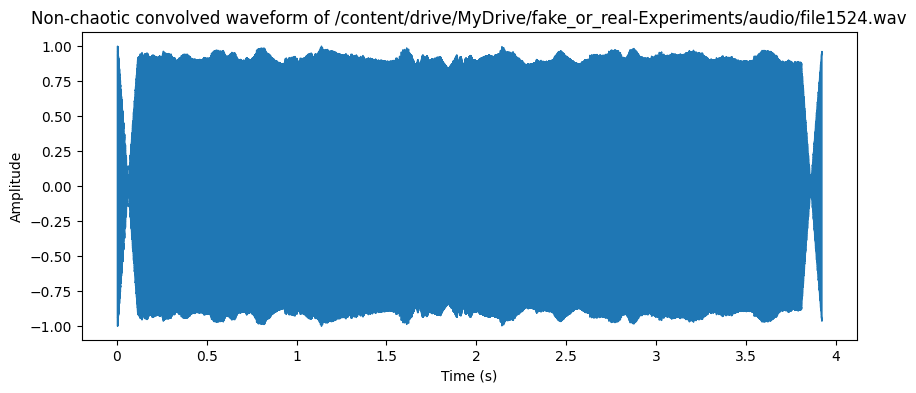

In [ ]:
#Then load the audio file
file_path = audio_files[3]
audio, sr = load_audio(file_path)
plot_waveform(audio, sr, f'Original waveform of {file_path}')

# Convolve with chaotic series and play/plot the result
audio_normalized = normalize_audio_standard_scaled(audio)

audio_chaotic = convolve_with_series(audio_normalized, chaotic_series_normalized)
audio_chaotic_scaled = normalize_audio_standard_scaled(audio_chaotic)
plot_waveform(audio_chaotic_scaled, sr, f'Chaotic convolved waveform of {file_path}')

# Convolve with non-chaotic series and play/plot the result

audio_non_chaotic = convolve_with_series(audio_normalized, non_chaotic_series_normalized)
audio_non_chaotic_scaled = normalize_audio_standard_scaled(audio_non_chaotic)
plot_waveform(audio_non_chaotic_scaled, sr, f'Non-chaotic convolved waveform of {file_path}')

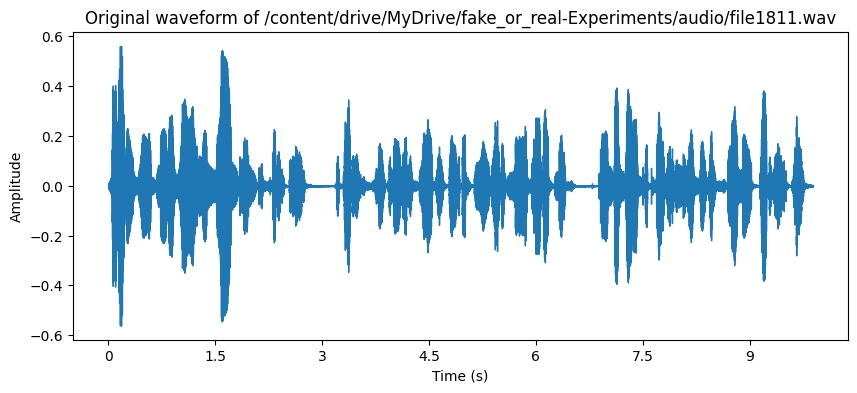

Mean: 2.023908746195957e-05, Standard Deviation: 0.057526491582393646
Min Value: -9.737077713012695, Max Value: 9.770854949951172
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: -4.4704845483767315, Standard Deviation: 1.926291871178977
Min Value: -7.566740114043637, Max Value: 7.514982368079256
Scaled Min Value: -1.0, Scaled Max Value: 1.0


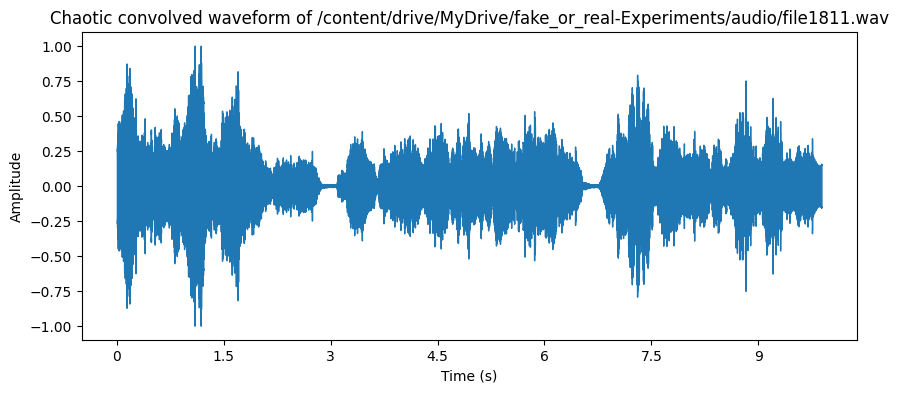

Mean: -2.926558741936721, Standard Deviation: 0.6771833641419152
Min Value: -7.4618964846088405, Max Value: 5.776343002183883
Scaled Min Value: -1.0, Scaled Max Value: 1.0


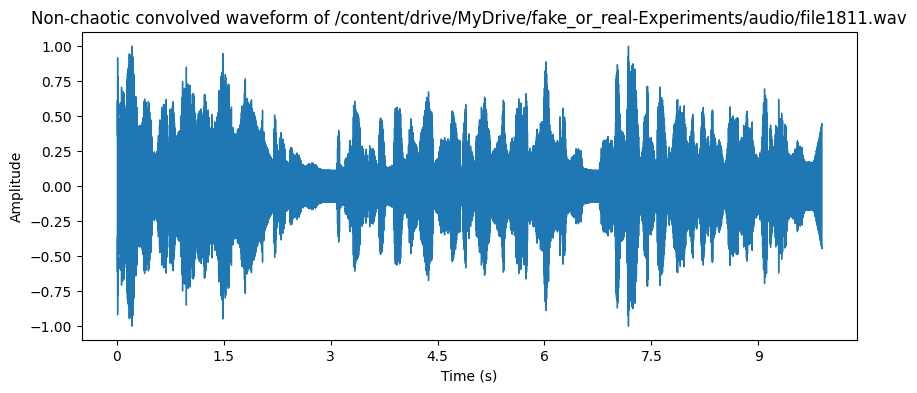

In [ ]:
#Then load the audio file
file_path = audio_files[4]
audio, sr = load_audio(file_path)
plot_waveform(audio, sr, f'Original waveform of {file_path}')

# Convolve with chaotic series and play/plot the result
audio_normalized = normalize_audio_standard_scaled(audio)

audio_chaotic = convolve_with_series(audio_normalized, chaotic_series_normalized)
audio_chaotic_scaled = normalize_audio_standard_scaled(audio_chaotic)
plot_waveform(audio_chaotic_scaled, sr, f'Chaotic convolved waveform of {file_path}')

# Convolve with non-chaotic series and play/plot the result

audio_non_chaotic = convolve_with_series(audio_normalized, non_chaotic_series_normalized)
audio_non_chaotic_scaled = normalize_audio_standard_scaled(audio_non_chaotic)
plot_waveform(audio_non_chaotic_scaled, sr, f'Non-chaotic convolved waveform of {file_path}')

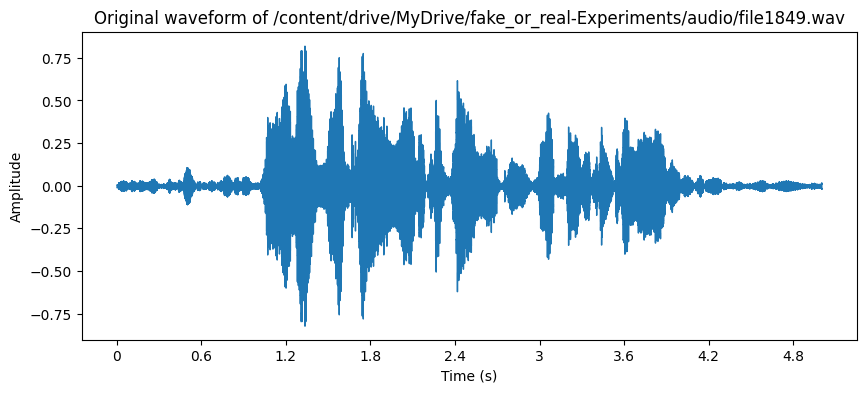

Mean: -0.009322669357061386, Standard Deviation: 0.09881062805652618
Min Value: -8.216346740722656, Max Value: 7.971620082855225
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: 38.75897303722584, Standard Deviation: 19.8283275341502
Min Value: -3.6720399123512113, Max Value: 4.402607281393877
Scaled Min Value: -1.0, Scaled Max Value: 1.0


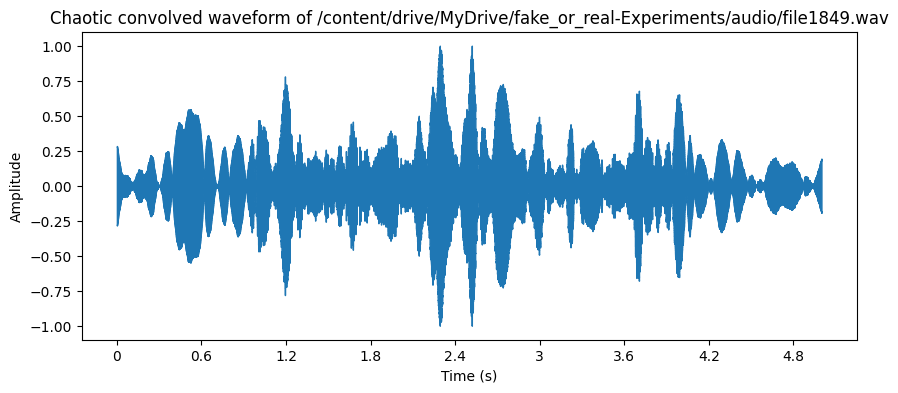

Mean: 25.37125511742884, Standard Deviation: 12.887946318960669
Min Value: -3.5502282360697874, Max Value: 4.0888438039222414
Scaled Min Value: -1.0, Scaled Max Value: 1.0


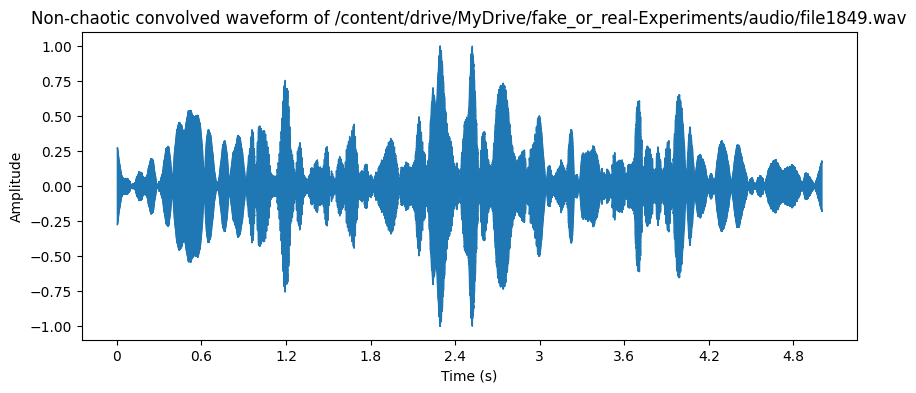

In [ ]:
#Then load the audio file
file_path = audio_files[5]
audio, sr = load_audio(file_path)
plot_waveform(audio, sr, f'Original waveform of {file_path}')

# Convolve with chaotic series and play/plot the result
audio_normalized = normalize_audio_standard_scaled(audio)

audio_chaotic = convolve_with_series(audio_normalized, chaotic_series_normalized)
audio_chaotic_scaled = normalize_audio_standard_scaled(audio_chaotic)
plot_waveform(audio_chaotic_scaled, sr, f'Chaotic convolved waveform of {file_path}')

# Convolve with non-chaotic series and play/plot the result

audio_non_chaotic = convolve_with_series(audio_normalized, non_chaotic_series_normalized)
audio_non_chaotic_scaled = normalize_audio_standard_scaled(audio_non_chaotic)
plot_waveform(audio_non_chaotic_scaled, sr, f'Non-chaotic convolved waveform of {file_path}')

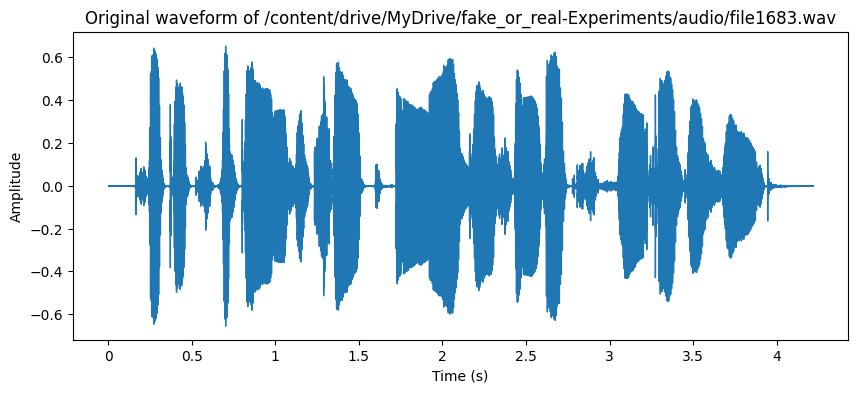

Mean: -8.435493327851873e-06, Standard Deviation: 0.14242978394031525
Min Value: -4.5948591232299805, Max Value: 3.295201539993286
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: 422.0405503482843, Standard Deviation: 28.5615330883738
Min Value: -7.304491374698009, Max Value: 1.1982285514509436
Scaled Min Value: -1.0, Scaled Max Value: 1.0


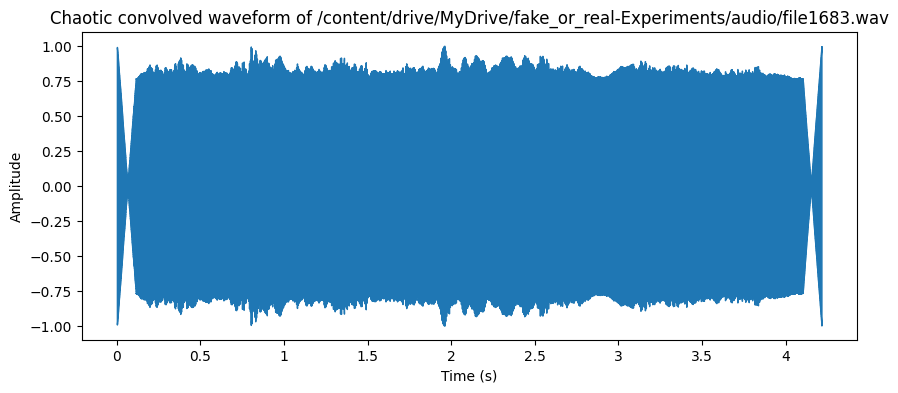

Mean: 276.2631159977039, Standard Deviation: 18.591147376199842
Min Value: -7.343722079840026, Max Value: 0.7308207663734052
Scaled Min Value: -1.0, Scaled Max Value: 1.0


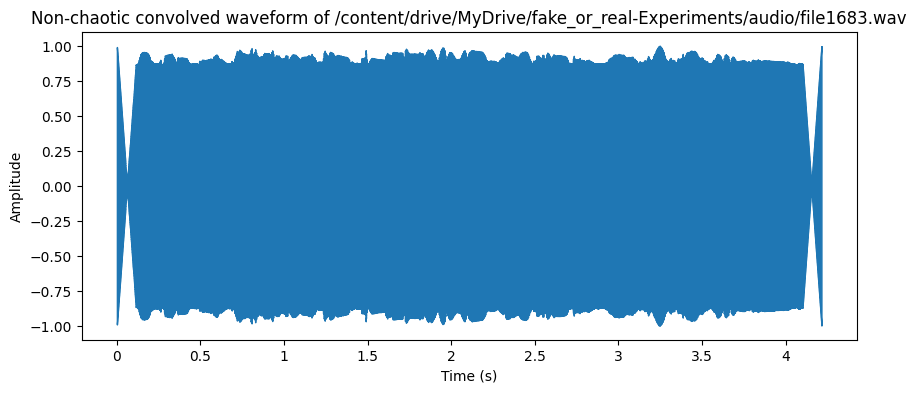

In [ ]:
#Then load the audio file
file_path = audio_files[6]
audio, sr = load_audio(file_path)
plot_waveform(audio, sr, f'Original waveform of {file_path}')

# Convolve with chaotic series and play/plot the result
audio_normalized = normalize_audio_standard_scaled(audio)

audio_chaotic = convolve_with_series(audio_normalized, chaotic_series_normalized)
audio_chaotic_scaled = normalize_audio_standard_scaled(audio_chaotic)
plot_waveform(audio_chaotic_scaled, sr, f'Chaotic convolved waveform of {file_path}')

# Convolve with non-chaotic series and play/plot the result

audio_non_chaotic = convolve_with_series(audio_normalized, non_chaotic_series_normalized)
audio_non_chaotic_scaled = normalize_audio_standard_scaled(audio_non_chaotic)
plot_waveform(audio_non_chaotic_scaled, sr, f'Non-chaotic convolved waveform of {file_path}')

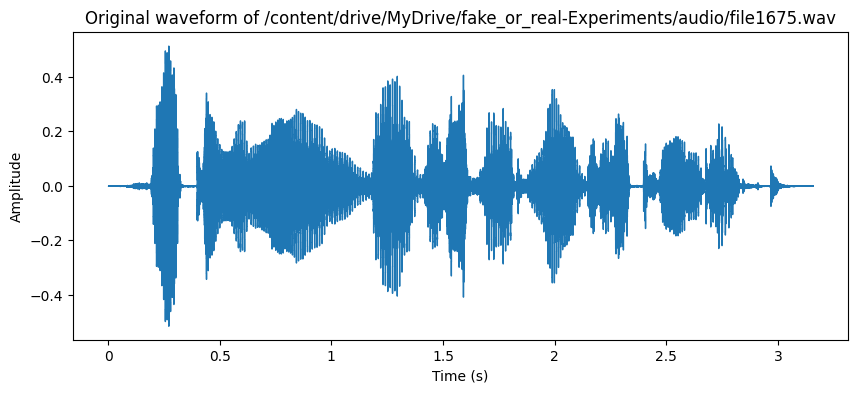

Mean: -3.148189352941699e-05, Standard Deviation: 0.06993282586336136
Min Value: -5.824873447418213, Max Value: 7.352961540222168
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: -295.7509486081528, Standard Deviation: 22.83568415438113
Min Value: -0.9044137178344496, Max Value: 6.3909196507034824
Scaled Min Value: -1.0, Scaled Max Value: 1.0


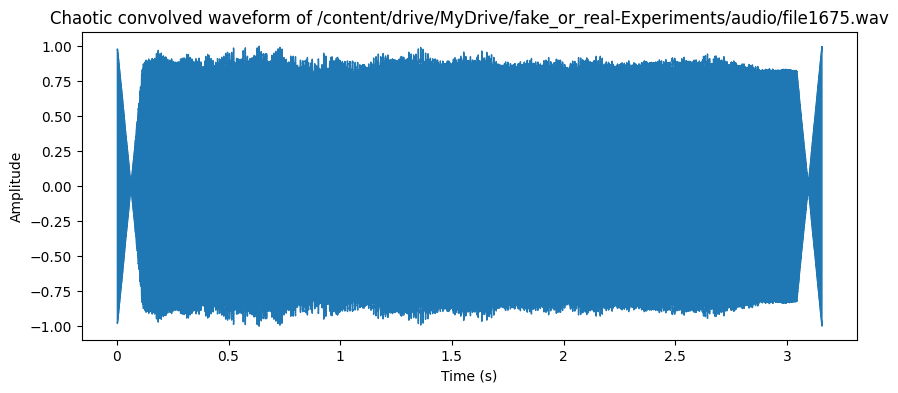

Mean: -193.58909319507225, Standard Deviation: 14.917050023083833
Min Value: -0.7554511778034685, Max Value: 6.402218247985322
Scaled Min Value: -1.0, Scaled Max Value: 1.0


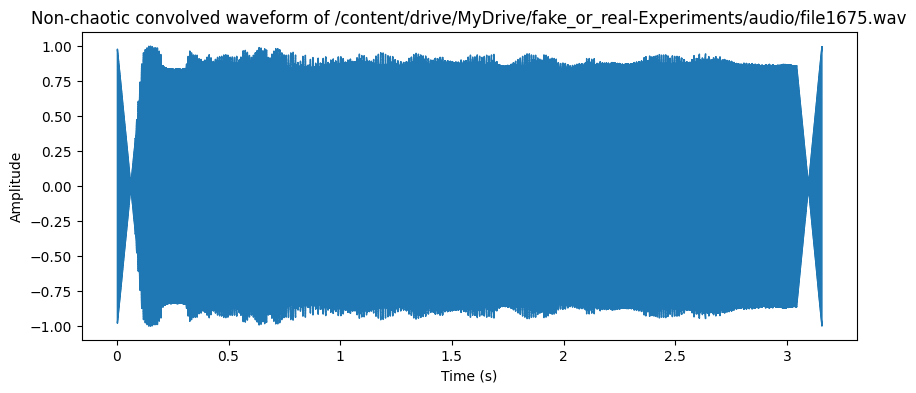

In [ ]:
#Then load the audio file
file_path = audio_files[7]
audio, sr = load_audio(file_path)
plot_waveform(audio, sr, f'Original waveform of {file_path}')

# Convolve with chaotic series and play/plot the result
audio_normalized = normalize_audio_standard_scaled(audio)

audio_chaotic = convolve_with_series(audio_normalized, chaotic_series_normalized)
audio_chaotic_scaled = normalize_audio_standard_scaled(audio_chaotic)
plot_waveform(audio_chaotic_scaled, sr, f'Chaotic convolved waveform of {file_path}')

# Convolve with non-chaotic series and play/plot the result

audio_non_chaotic = convolve_with_series(audio_normalized, non_chaotic_series_normalized)
audio_non_chaotic_scaled = normalize_audio_standard_scaled(audio_non_chaotic)
plot_waveform(audio_non_chaotic_scaled, sr, f'Non-chaotic convolved waveform of {file_path}')

In [ ]:
# Binary classification labels
labels_chaotic = np.ones(len(labels_array))
labels_non_chaotic = np.zeros(len(labels_array))

In [ ]:
# Concatenating audio files and labels
audio_files_augmented = np.concatenate((audio_files_chaotic_normalized, audio_files_non_chaotic_normalized), axis=0)
labels_augmented = np.concatenate((labels_chaotic, labels_non_chaotic), axis=0)

In [ ]:
#Add
# Concatenating audio files and labels
audio_files_augmented_T = np.concatenate((audio_files_chaotic_normalized_T, audio_files_non_chaotic_normalized_T), axis=0)
labels_augmented_T = np.concatenate((labels_chaotic, labels_non_chaotic), axis=0)

In [ ]:
# Encoding labels
encoder = LabelEncoder()
labels_augmented_encoded = encoder.fit_transform(labels_augmented)

In [ ]:
#Add
# Encoding labels
encoder = LabelEncoder()
labels_augmented_encoded_T = encoder.fit_transform(labels_augmented_T)

In [ ]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(audio_files_augmented, labels_augmented_encoded, test_size=0.2, random_state=42)

In [ ]:
# Adding channel dimension for 1D CNN
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [ ]:
#Add
# Adding channel dimension for 1D CNN
X = audio_files_augmented_T[..., np.newaxis]
y = labels_augmented_encoded_T

In [ ]:
# Removing NaN values
def remove_nan_samples(X, y):
    mask = ~np.isnan(X).any(axis=(1,2))
    return X[mask], y[mask]

In [ ]:
X_train, y_train = remove_nan_samples(X_train, y_train)
X_test, y_test = remove_nan_samples(X_test, y_test)

In [ ]:
#Add
X, y = remove_nan_samples(X, y)

# Use the entire dataset as the test set
X_test_T = X
y_test_T = y

# Print shapes to verify
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Print shapes to verify
print(f"X_test shape: {X_test_T.shape}")
print(f"y_test shape: {y_test_T.shape}")

X_test shape: (3199, 10000, 1)
y_test shape: (3199,)
X_test shape: (15990, 10000, 1)
y_test shape: (15990,)


Model- Proposed 1

In [ ]:
!pip install tensorflow_addons

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, Activation, Bidirectional, Add, Layer
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow_addons.layers import WeightNormalization

class Attention(Layer):
    def _init_(self, **kwargs):
        super(Attention, self)._init_(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], input_shape[-1]), initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[-1],), initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x + x * a  # Adding skip connection
        return K.sum(output, axis=1)


def residual_block(x, filters, kernel_size, dilation_rate, pool_size):
    shortcut = x
    x = Conv1D(filters, kernel_size, padding='same', dilation_rate=dilation_rate, kernel_regularizer=l2(Config.l2_lambda))(x)     #Removing Weight Normalization
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(filters, kernel_size, padding='same', dilation_rate=dilation_rate, kernel_regularizer=l2(Config.l2_lambda))(x)     #Removing Weight Normalization
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size)(x)
    shortcut = Conv1D(filters, 1, padding='same', kernel_regularizer=l2(Config.l2_lambda))(shortcut)                              #Removing Weight Normalization
    shortcut = MaxPooling1D(pool_size)(shortcut)
    x = Add()([x, shortcut])
    return x

def create_network_with_attention_and_dilation(input_shape):
    input_layer = Input(shape=input_shape)

    # CNN part with residual blocks and dilation
    x = residual_block(input_layer, 64, 3, 1, 2)
    x = residual_block(x, 128, 3, 2, 2)
    x = residual_block(x, 256, 3, 4, 2)
    x = Dropout(0.3)(x)

    # Batch normalization before the start of BiLSTM layers
    x = BatchNormalization()(x)

    # BiLSTM part
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)

    # Batch normalization after the BiLSTM layers
    x = BatchNormalization()(x)

    # Attention layer
    x = Attention()(x)
    x = BatchNormalization()(x)

    # Dense Projection
    x = (Dense(128, activation='relu', kernel_regularizer=l2(Config.l2_lambda))(x))                                             #Removing Weight Normalization
    x = Dropout(0.3)(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# Instantiate and compile the model
model_att_with_dil = create_network_with_attention_and_dilation(Config.input_shape)
model_att_with_dil.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=Config.learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model_att_with_dil.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 10000, 1)]           0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 10000, 64)            256       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 10000, 64)            256       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 10000, 64)            0         ['batch_normalization[0][0

In [ ]:
# Train the model
checkpoint = ModelCheckpoint(Config.best_model_path, monitor='val_accuracy', save_best_only=True, mode='max')
history = model_att_with_dil.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2, callbacks=[checkpoint])

Epoch 1/40
320/320 [==============================] - 173s 479ms/step - loss: 1.3862 - accuracy: 0.8685 - val_loss: 1.7261 - val_accuracy: 0.6714
Epoch 2/40
320/320 [==============================] - 150s 468ms/step - loss: 1.2383 - accuracy: 0.9257 - val_loss: 1.2080 - val_accuracy: 0.9250
Epoch 3/40
320/320 [==============================] - 149s 466ms/step - loss: 1.1626 - accuracy: 0.9382 - val_loss: 1.0983 - val_accuracy: 0.9734
Epoch 4/40
320/320 [==============================] - 149s 465ms/step - loss: 1.0984 - accuracy: 0.9505 - val_loss: 1.0875 - val_accuracy: 0.9402
Epoch 5/40
320/320 [==============================] - 149s 466ms/step - loss: 1.0341 - accuracy: 0.9587 - val_loss: 0.9919 - val_accuracy: 0.9640
Epoch 6/40
320/320 [==============================] - 149s 465ms/step - loss: 0.9748 - accuracy: 0.9645 - val_loss: 0.9651 - val_accuracy: 0.9558
Epoch 7/40
320/320 [==============================] - 149s 467ms/step - loss: 0.9164 - accuracy: 0.9718 - val_loss: 0.8612 -

In [ ]:
# Evaluate the model- for K_NC=2.1, K_C=2.3
model_att_with_dil.load_weights(Config.best_model_path) # Use the correct model name
loss, accuracy = model_att_with_dil.evaluate(X_test, y_test) # Use the correct model name
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

100/100 [==============================] - 16s 161ms/step - loss: 0.1216 - accuracy: 0.9991
Test loss: 0.12162677198648453
Test accuracy: 0.999062180519104


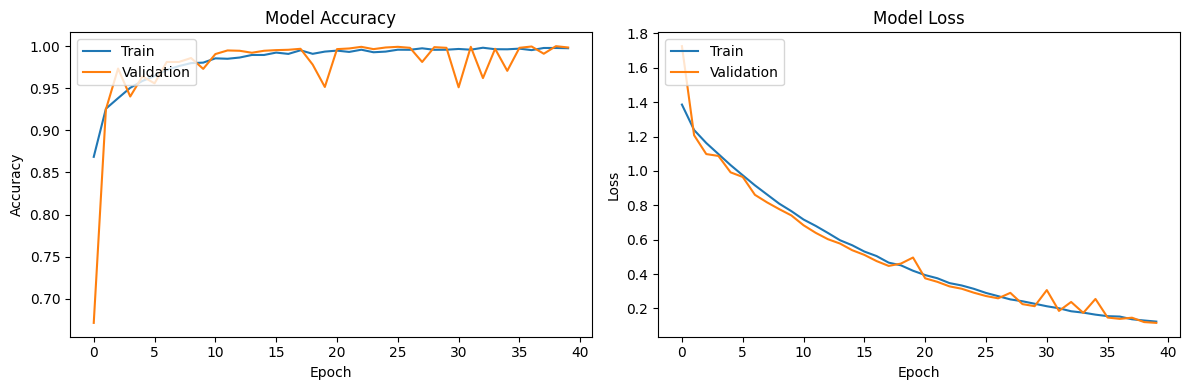

In [ ]:
# Assuming `history` is the variable storing the history of the training process
def plot_training_history(history):
    # Plotting training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plotting training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [ ]:
#Add
# Assuming `history` is the variable storing the history of the training process
def plot_training_history(history_old):
    # Plotting training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history_old.history['accuracy'])
    plt.plot(history_old.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plotting training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history_old.history['loss'])
    plt.plot(history_old.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_history(history_old)

Model-1: ShallowNet

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential

# Define the shallow neural network model
def create_shallownet(input_shape):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))  # Flatten the input
    model.add(Dense(100, activation='sigmoid', input_shape=input_shape))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Create the model
model_shallownet = create_shallownet(Config.input_shape)
model_shallownet.compile(optimizer=Adam(learning_rate=Config.learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model_shallownet.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)                  │ (None, 10000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 100)                 │       1,000,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,000,201 (3.82 MB)

 Trainable params: 1,000,201 (3.82 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training the model- for K_NC=2.1.K_C=2.3
checkpoint_1 = ModelCheckpoint(Config.best_model_path_1, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
history_1 = model_shallownet.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2, callbacks=[checkpoint_1])

Epoch 1/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5170 - loss: 0.7166
Epoch 1: val_accuracy improved from -inf to 0.45877, saving model to Shallownet_fake_or_real.keras
320/320 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5170 - loss: 0.7166 - val_accuracy: 0.4588 - val_loss: 0.7114
Epoch 2/60
303/320 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5277 - loss: 0.6923
Epoch 2: val_accuracy did not improve from 0.45877
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5277 - loss: 0.6925 - val_accuracy: 0.4553 - val_loss: 0.7261
Epoch 3/60
295/320 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5579 - loss: 0.6823
Epoch 3: val_accuracy improved from 0.45877 to 0.46659, saving model to Shallownet_fake_or_real.keras
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5569 - loss: 0.6827 - val_accuracy: 0.4666 - val_loss: 0.7335
Epoch 4/60
298/320 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5832 - loss: 0.6722
Epoch 4: val_accuracy did not improve from 0.46659
32

In [ ]:
# Evaluate the model- for K_NC=2.1, K_C=2.3
model_shallownet.load_weights(Config.best_model_path_1)
loss, accuracy = model_shallownet.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4993 - loss: 0.7552
Test loss: 0.7621294856071472
Test accuracy: 0.4932791590690613


In [ ]:
#Add
# Evaluate the model- for K_NC=2.0, K_C=2.4
model_shallownet.load_weights(Config.best_model_path_1)
loss, accuracy = model_shallownet.evaluate(X_test_T, y_test_T)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4656 - loss: 0.7767
Test loss: 0.7186149954795837
Test accuracy: 0.5537835955619812


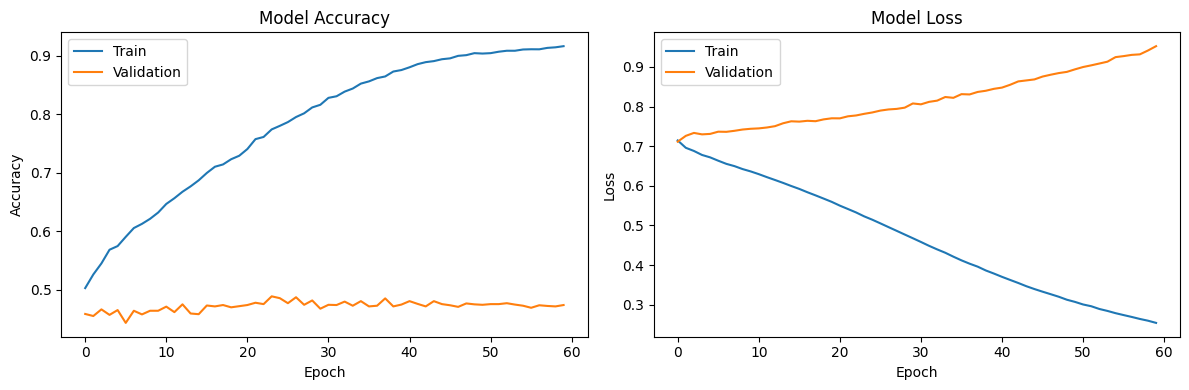

In [ ]:
import matplotlib.pyplot as plt

# Assuming `history` is the variable storing the history of the training process
def plot_training_history(history_1):
    # Plotting training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history_1.history['accuracy'])
    plt.plot(history_1.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plotting training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history_1.history['loss'])
    plt.plot(history_1.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Assuming `history` contains the training history from model.fit
plot_training_history(history_1)

Model-2:MLP

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the MLP model
def create_mlp(input_shape):
    model = Sequential()

    # Input dropout
    model.add(Input(shape=input_shape))
    model.add(Dropout(0.1))

    # Flatten the input
    model.add(Flatten())

    # First hidden layer
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.2))

    # Second hidden layer
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.2))

    # Third hidden layer
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.2))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    model.add(Dropout(0.3))

    return model

# Create the model
model_mlp = create_mlp(Config.input_shape)
model_mlp.compile(optimizer=Adam(learning_rate=Config.learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model_mlp.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dropout_15 (Dropout)                 │ (None, 10000, 1)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 10000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 500)                 │       5,000,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 500)                 │         250,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 500)                 │         250,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │             501 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,502,001 (20.99 MB)

 Trainable params: 5,502,001 (20.99 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training the model- for K_NC=2.1.K_C=2.3
checkpoint_2 = ModelCheckpoint(Config.best_model_path_2, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
history_2 = model_mlp.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2, callbacks=[checkpoint_2])

Epoch 1/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5564 - loss: 2.9212
Epoch 1: val_accuracy improved from -inf to 0.49355, saving model to MLP_fake_or_real.keras
320/320 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.5564 - loss: 2.9213 - val_accuracy: 0.4936 - val_loss: 0.7721
Epoch 2/60
314/320 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5728 - loss: 2.9672
Epoch 2: val_accuracy improved from 0.49355 to 0.50762, saving model to MLP_fake_or_real.keras
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5728 - loss: 2.9688 - val_accuracy: 0.5076 - val_loss: 0.8321
Epoch 3/60
303/320 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5688 - loss: 3.2303
Epoch 3: val_accuracy did not improve from 0.50762
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5685 - loss: 3.2287 - val_accuracy: 0.4924 - val_loss: 0.8256
Epoch 4/60
317/320 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5766 - loss: 3.2799
Epoch 4: val_accuracy did not improve from 0.50762
320/320 ━━━━━━

In [ ]:
# Evaluate the model- for K_NC=2.1, K_C=2.3
model_mlp.load_weights(Config.best_model_path_2)
loss, accuracy = model_mlp.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7287 - loss: 0.5080
Test loss: 0.5138888955116272
Test accuracy: 0.7299156188964844


In [ ]:
#Add
# Evaluate the model- for K_NC=2.0, K_C=2.4
model_mlp.load_weights(Config.best_model_path_2)
loss, accuracy = model_mlp.evaluate(X_test_T, y_test_T)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3900 - loss: 1.0352
Test loss: 0.7918633222579956
Test accuracy: 0.5838649272918701


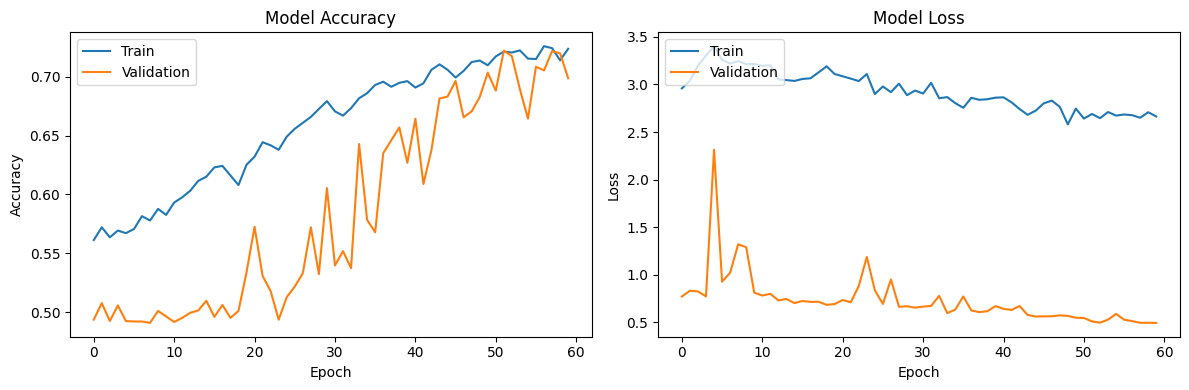

In [ ]:
import matplotlib.pyplot as plt

# Assuming `history` is the variable storing the history of the training process
def plot_training_history(history_2):
    # Plotting training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history_2.history['accuracy'])
    plt.plot(history_2.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plotting training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history_2.history['loss'])
    plt.plot(history_2.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Assuming `history` contains the training history from model.fit
plot_training_history(history_2)

Model-3:FCN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, GlobalAveragePooling1D, Dense, Softmax
from tensorflow.keras.optimizers import Adam

def create_fcn_model(input_shape):
    inputs = Input(shape=input_shape)

    # First convolutional block
    x = Conv1D(filters=64, kernel_size=8, strides=1, padding='valid')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second convolutional block
    x = Conv1D(filters=128, kernel_size=5, strides=1, padding='valid')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Third convolutional block
    x = Conv1D(filters=64, kernel_size=3, strides=1, padding='valid')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Global average pooling layer
    x = GlobalAveragePooling1D()(x)

    # Softmax layer (classification layer)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model


In [ ]:
# Create the model
model_fcn =  create_fcn_model(Config.input_shape)
model_fcn.compile(optimizer=Adam(learning_rate=Config.learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model_fcn.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 10000, 1)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_93 (Conv1D)                   │ (None, 9993, 64)            │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_89               │ (None, 9993, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 9993, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_94 (Conv1D)                   │ (None, 9989, 128)           │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_90               │ (None, 9989, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_5 (ReLU)                       │ (None, 9989, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_95 (Conv1D)                   │ (None, 9987, 64)            │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_91               │ (None, 9987, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_6 (ReLU)                       │ (None, 9987, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_2           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,393 (263.25 KB)

 Trainable params: 66,881 (261.25 KB)

 Non-trainable params: 512 (2.00 KB)

In [ ]:
# Training the model- for K_NC=2.1.K_C=2.3
checkpoint_3 = ModelCheckpoint(Config.best_model_path_3, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
history_3 = model_fcn.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2, callbacks=[checkpoint_3])

Epoch 1/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6796 - loss: 0.5936
Epoch 1: val_accuracy improved from -inf to 0.49707, saving model to FCN_fake_or_real.keras
320/320 ━━━━━━━━━━━━━━━━━━━━ 33s 81ms/step - accuracy: 0.6798 - loss: 0.5934 - val_accuracy: 0.4971 - val_loss: 0.7168
Epoch 2/60
319/320 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8313 - loss: 0.3808
Epoch 2: val_accuracy improved from 0.49707 to 0.84525, saving model to FCN_fake_or_real.keras
320/320 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.8313 - loss: 0.3806 - val_accuracy: 0.8453 - val_loss: 0.3844
Epoch 3/60
319/320 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8690 - loss: 0.3108
Epoch 3: val_accuracy improved from 0.84525 to 0.88159, saving model to FCN_fake_or_real.keras
320/320 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - accuracy: 0.8690 - loss: 0.3107 - val_accuracy: 0.8816 - val_loss: 0.2933
Epoch 4/60
319/320 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8768 - loss: 0.2833
Epoch 4: val_

In [ ]:
# Evaluate the model- for K_NC=2.1, K_C=2.3
model_fcn.load_weights(Config.best_model_path_3)
loss, accuracy = model_fcn.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9766 - loss: 0.0697
Test loss: 0.06800088286399841
Test accuracy: 0.9743669629096985


In [ ]:
#Add
# Evaluate the model- for K_NC=2.0, K_C=2.4
model_fcn.load_weights(Config.best_model_path_3)
loss, accuracy = model_fcn.evaluate(X_test_T, y_test_T)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8212 - loss: 1.6616
Test loss: 5.187557697296143
Test accuracy: 0.531582236289978


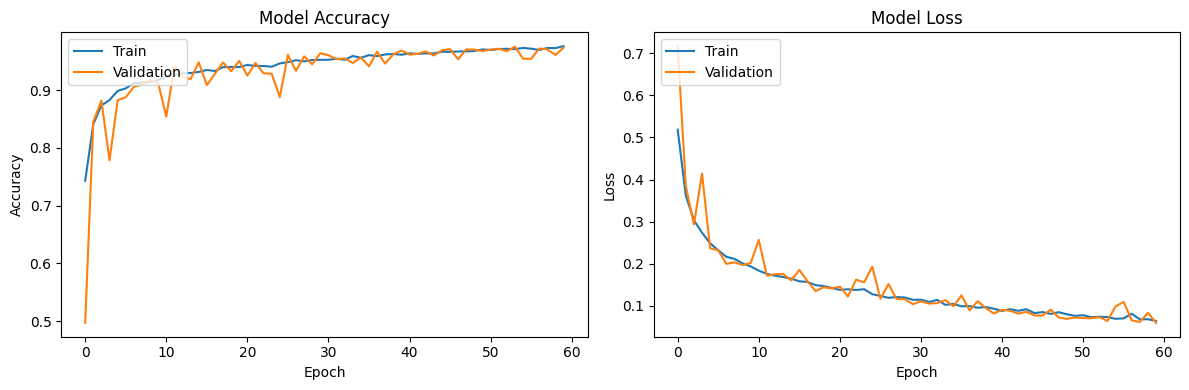

In [ ]:
import matplotlib.pyplot as plt

# Assuming `history` is the variable storing the history of the training process
def plot_training_history(history_3):
    # Plotting training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history_3.history['accuracy'])
    plt.plot(history_3.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plotting training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history_3.history['loss'])
    plt.plot(history_3.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Assuming `history` contains the training history from model.fit
plot_training_history(history_3)

Model-4:LKCNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, ReLU

def create_lkcnn(input_shape):
    model = Sequential()

    # First convolutional layer
    model.add(Conv1D(filters=5, kernel_size=100, padding='same', input_shape=input_shape))
    model.add(ReLU())

    # Second convolutional layer
    model.add(Conv1D(filters=5, kernel_size=100, padding='same'))
    model.add(ReLU())

    # Max pooling layer
    model.add(MaxPooling1D(pool_size=2))

    # Dropout layer
    model.add(Dropout(0.5))

    # Flatten layer
    model.add(Flatten())

    # Fully connected layer 1
    model.add(Dense(100))
    model.add(ReLU())

    # Fully connected layer 2
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

    return model

In [ ]:
# Create the model
model_lkcnn = create_lkcnn(Config.input_shape)
model_lkcnn.compile(optimizer=Adam(learning_rate=Config.learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model_lkcnn.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_91 (Conv1D)                   │ (None, 10000, 5)            │             505 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 10000, 5)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_92 (Conv1D)                   │ (None, 10000, 5)            │           2,505 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 10000, 5)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_18 (MaxPooling1D)      │ (None, 5000, 5)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 5000, 5)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 25000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 100)                 │       2,500,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,503,211 (9.55 MB)

 Trainable params: 2,503,211 (9.55 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
checkpoint_5 = ModelCheckpoint(Config.best_model_path_5, monitor='val_accuracy', save_best_only=True, mode='max')
history_5 = model_lkcnn.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2, callbacks=[checkpoint_5])

Epoch 1/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.6600 - loss: 0.5967 - val_accuracy: 0.8113 - val_loss: 0.3962
Epoch 2/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.8337 - loss: 0.3501 - val_accuracy: 0.8636 - val_loss: 0.2967
Epoch 3/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.8795 - loss: 0.2602 - val_accuracy: 0.8828 - val_loss: 0.2395
Epoch 4/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.8996 - loss: 0.2206 - val_accuracy: 0.8742 - val_loss: 0.2499
Epoch 5/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.9127 - loss: 0.1938 - val_accuracy: 0.9207 - val_loss: 0.1888
Epoch 6/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.9243 - loss: 0.1656 - val_accuracy: 0.9109 - val_loss: 0.1855
Epoch 7/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.9271 - loss: 0.1563 - val_accuracy: 0.9226 - val_loss: 0.1807
Epoch 8/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.9300 - loss: 0.1514 - 

In [ ]:
# Evaluate the model- for K_NC=2.1, K_C=2.3
model_lkcnn.load_weights(Config.best_model_path_5)
loss, accuracy = model_lkcnn.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9913 - loss: 0.0703
Test loss: 0.053812507539987564
Test accuracy: 0.9934354424476624


In [ ]:
#Add
# Evaluate the model- for K_NC=2.0, K_C=2.4
model_lkcnn.load_weights(Config.best_model_path_5)
loss, accuracy = model_lkcnn.evaluate(X_test_T, y_test_T)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9367 - loss: 0.6699
Test loss: 1.8967617750167847
Test accuracy: 0.8298937082290649


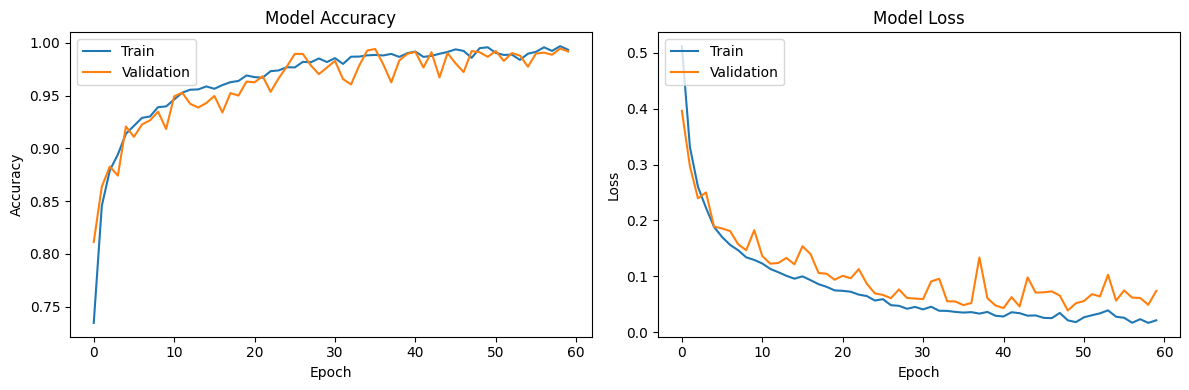

In [ ]:
import matplotlib.pyplot as plt

# Assuming `history` is the variable storing the history of the training process
def plot_training_history(history_5):
    # Plotting training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history_5.history['accuracy'])
    plt.plot(history_5.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plotting training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history_5.history['loss'])
    plt.plot(history_5.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_history(history_5)

Proposed-2: Model after removing Bi-LSTM and adding attention between residual blocks

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D, Activation, Bidirectional, Add, Layer
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
#from tensorflow_addons.layers import WeightNormalization

class Attention(Layer):
    def _init_(self, **kwargs):
        super(Attention, self)._init_(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], input_shape[-1]), initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[-1],), initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x + x * a  # Adding skip connection
        #return K.sum(output, axis=1)
        return output


def residual_block(x, filters, kernel_size, dilation_rate, pool_size):
    shortcut = x
    x = Conv1D(filters, kernel_size, padding='same', dilation_rate=dilation_rate, kernel_regularizer=l2(Config.l2_lambda))(x)     #Removing Weight Normalization
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(filters, kernel_size, padding='same', dilation_rate=dilation_rate, kernel_regularizer=l2(Config.l2_lambda))(x)     #Removing Weight Normalization
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size)(x)
    shortcut = Conv1D(filters, 1, padding='same', kernel_regularizer=l2(Config.l2_lambda))(shortcut)                              #Removing Weight Normalization
    shortcut = MaxPooling1D(pool_size)(shortcut)
    x = Add()([x, shortcut])
    return x

def create_network_with_attention_and_dilation(input_shape):
    input_layer = Input(shape=input_shape)

    # CNN part with residual blocks and dilation
    x = residual_block(input_layer, 64, 3, 1, 2)#Add attention layer between the blocks
    x = Attention()(x)
    x = residual_block(x, 128, 3, 2, 2)
    x = Attention()(x)
    x = residual_block(x, 256, 3, 4, 2)
    x = Dropout(0.3)(x)

    # Batch normalization before the start of BiLSTM layers
    x = BatchNormalization()(x)

    # BiLSTM part
    #x = Bidirectional(LSTM(128, return_sequences=True))(x)
    #x = Bidirectional(LSTM(128, return_sequences=True))(x)

    # Batch normalization after the BiLSTM layers
    #x = BatchNormalization()(x)

    # Attention layer
    x = Attention()(x)
    x = BatchNormalization()(x)

    # Global Average Pooling layer
    x = GlobalAveragePooling1D()(x)  # This reduces the dimensions

    # Dense Projection
    x = (Dense(128, activation='relu', kernel_regularizer=l2(Config.l2_lambda))(x))                                             #Removing Weight Normalization
    x = Dropout(0.3)(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [ ]:
# Instantiate and compile the model
model_att_with_dil_2 = create_network_with_attention_and_dilation(Config.input_shape)
model_att_with_dil_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=Config.learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model_att_with_dil_2.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 10000, 1)       │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_82 (Conv1D)        │ (None, 10000, 64)      │            256 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_81    │ (None, 10000, 64)      │            256 │ conv1d_82[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_9 (Activation) │ (None, 10000, 64)      │              0 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_83 (Conv1D)        │ (None, 10000, 64)      │         12,352 │ activation_9[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_82    │ (None, 10000, 64)      │            256 │ conv1d_83[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_10             │ (None, 10000, 64)      │              0 │ batch_normalization_8… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_84 (Conv1D)        │ (None, 10000, 64)      │            128 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_12          │ (None, 5000, 64)       │              0 │ activation_10[0][0]    │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_13          │ (None, 5000, 64)       │              0 │ conv1d_84[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_11 (Add)              │ (None, 5000, 64)       │              0 │ max_pooling1d_12[0][0… │
│                           │                        │                │ max_pooling1d_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 5000, 64)       │          4,160 │ add_11[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_85 (Conv1D)        │ (None, 5000, 128)      │         24,704 │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_83    │ (None, 5000, 128)      │            512 │ conv1d_85[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_11             │ (None, 5000, 128)      │              0 │ batch_normalization_8… │
│ (Activation)              │                        │                │                        │
├──────────────────────

 Total params: 548,609 (2.09 MB)

 Trainable params: 545,793 (2.08 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [ ]:
# Train the model
checkpoint_new = ModelCheckpoint(Config.best_model_path_new, monitor='val_accuracy', save_best_only=True, mode='max')
history_new = model_att_with_dil_2.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2, callbacks=[checkpoint_new])

Epoch 1/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 110s 284ms/step - accuracy: 0.7554 - loss: 1.5725 - val_accuracy: 0.7495 - val_loss: 1.5703
Epoch 2/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 73s 228ms/step - accuracy: 0.9156 - loss: 1.1826 - val_accuracy: 0.8894 - val_loss: 1.1780
Epoch 3/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 73s 227ms/step - accuracy: 0.9370 - loss: 1.0513 - val_accuracy: 0.9301 - val_loss: 0.9929
Epoch 4/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 73s 227ms/step - accuracy: 0.9412 - loss: 0.9638 - val_accuracy: 0.9484 - val_loss: 0.8992
Epoch 5/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 73s 227ms/step - accuracy: 0.9547 - loss: 0.8795 - val_accuracy: 0.9637 - val_loss: 0.8031
Epoch 6/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 73s 227ms/step - accuracy: 0.9636 - loss: 0.7937 - val_accuracy: 0.9769 - val_loss: 0.7283
Epoch 7/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 73s 227ms/step - accuracy: 0.9652 - loss: 0.7387 - val_accuracy: 0.9726 - val_loss: 0.6859
Epoch 8/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 73s 227ms/step - accuracy: 0.9630 - loss: 

In [ ]:
# Evaluate the model- for K_NC=2.1, K_C=2.3
model_att_with_dil_2.load_weights(Config.best_model_path_new)
loss, accuracy = model_att_with_dil_2.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9990 - loss: 0.1210
Test loss: 0.12026010453701019
Test accuracy: 0.999062180519104


In [ ]:
#Add
# Evaluate the model- for K_NC=2.0, K_C=2.4
model_att_with_dil_2.load_weights(Config.best_model_path_new)
loss, accuracy = model_att_with_dil_2.evaluate(X_test_T, y_test_T)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - accuracy: 0.8513 - loss: 1.0892
Test loss: 3.2452144622802734
Test accuracy: 0.5203251838684082


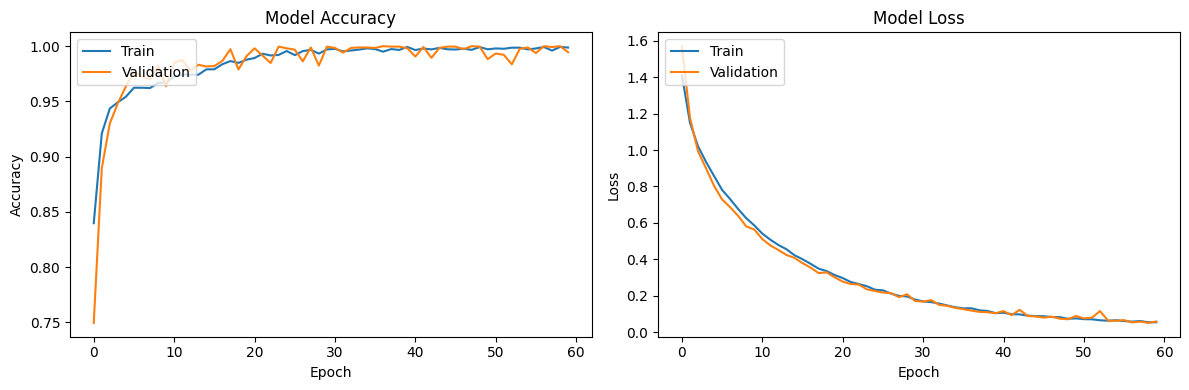

In [ ]:
import matplotlib.pyplot as plt

# Assuming `history` is the variable storing the history of the training process
def plot_training_history(history_new):
    # Plotting training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history_new.history['accuracy'])
    plt.plot(history_new.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plotting training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history_new.history['loss'])
    plt.plot(history_new.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_history(history_new)

**ResNet-2**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, GlobalAveragePooling1D, Add, Activation, BatchNormalization, Dense
from tensorflow.keras.optimizers import Adam

def fcn_block(x, filters, kernel_size):
    x = Conv1D(filters=filters, kernel_size=kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def residual_block(x, filters, kernel_size):
    shortcut = x
    x = fcn_block(x, filters, kernel_size)
    x = fcn_block(x, filters, kernel_size)
    x = Conv1D(filters=filters, kernel_size=kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    if x.shape[-1] != shortcut.shape[-1]:
        shortcut = Conv1D(filters=filters, kernel_size=1, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def create_resnet(input_shape, nb_classes=1):
    inputs = Input(shape=input_shape)
    x = BatchNormalization()(inputs)

    # First residual block with 64 filters
    x = residual_block(x, 64, 8)

    # Second residual block with 128 filters
    x = residual_block(x, 128, 5)

    # Third residual block with 128 filters
    x = residual_block(x, 128, 3)

    # Global average pooling layer
    x = GlobalAveragePooling1D()(x)

    # Dense layer with sigmoid activation for binary classification
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
# Instantiate and compile the model
model_resnet2 = create_resnet(Config.input_shape)
model_resnet2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=Config.learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model_resnet2.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 10000, 1)       │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_69    │ (None, 10000, 1)       │              4 │ input_layer_5[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_71 (Conv1D)        │ (None, 10000, 64)      │            576 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_70    │ (None, 10000, 64)      │            256 │ conv1d_71[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 10000, 64)      │              0 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_72 (Conv1D)        │ (None, 10000, 64)      │         32,832 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_71    │ (None, 10000, 64)      │            256 │ conv1d_72[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 10000, 64)      │              0 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_73 (Conv1D)        │ (None, 10000, 64)      │         32,832 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_74 (Conv1D)        │ (None, 10000, 64)      │            128 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_72    │ (None, 10000, 64)      │            256 │ conv1d_73[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_73    │ (None, 10000, 64)      │            256 │ conv1d_74[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_8 (Add)               │ (None, 10000, 64)      │              0 │ batch_normalization_7… │
│                           │                        │                │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 10000, 64)      │              0 │ add_8[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_75 (Conv1D)        │ (None, 10000, 128)     │         41,088 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_74    │ (None, 10000, 128)     │            512 │ conv1d_75[0][0]        │
│ (BatchNormalization) 

 Total params: 432,453 (1.65 MB)

 Trainable params: 430,147 (1.64 MB)

 Non-trainable params: 2,306 (9.01 KB)

In [ ]:
# Train the model
checkpoint_r = ModelCheckpoint(Config.best_model_path_r, monitor='val_accuracy', save_best_only=True, mode='max')
history_r = model_resnet2.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2, callbacks=[checkpoint_r])

Epoch 1/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 138s 370ms/step - accuracy: 0.8166 - loss: 0.3730 - val_accuracy: 0.7819 - val_loss: 0.4120
Epoch 2/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 102s 318ms/step - accuracy: 0.9555 - loss: 0.1041 - val_accuracy: 0.9613 - val_loss: 0.0849
Epoch 3/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 102s 318ms/step - accuracy: 0.9672 - loss: 0.0760 - val_accuracy: 0.9891 - val_loss: 0.0397
Epoch 4/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 102s 318ms/step - accuracy: 0.9846 - loss: 0.0469 - val_accuracy: 0.9918 - val_loss: 0.0308
Epoch 5/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 102s 318ms/step - accuracy: 0.9857 - loss: 0.0400 - val_accuracy: 0.9984 - val_loss: 0.0178
Epoch 6/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 102s 318ms/step - accuracy: 0.9936 - loss: 0.0246 - val_accuracy: 0.9953 - val_loss: 0.0173
Epoch 7/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 102s 318ms/step - accuracy: 0.9932 - loss: 0.0217 - val_accuracy: 0.9973 - val_loss: 0.0113
Epoch 8/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 102s 318ms/step - accuracy: 0.9978 -

In [ ]:
# Evaluate the model- for K_NC=2.1, K_C=2.3
model_resnet2.load_weights(Config.best_model_path_r)
loss, accuracy = model_resnet2.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 1.0000 - loss: 4.3048e-04
Test loss: 0.00037385986070148647
Test accuracy: 1.0


In [ ]:
#Add

# Evaluate the model- for K_NC=2.0, K_C=2.4
model_resnet2.load_weights(Config.best_model_path_r)
loss, accuracy = model_resnet2.evaluate(X_test_T, y_test_T)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.8451 - loss: 2.7629
Test loss: 8.885210990905762
Test accuracy: 0.5015009641647339


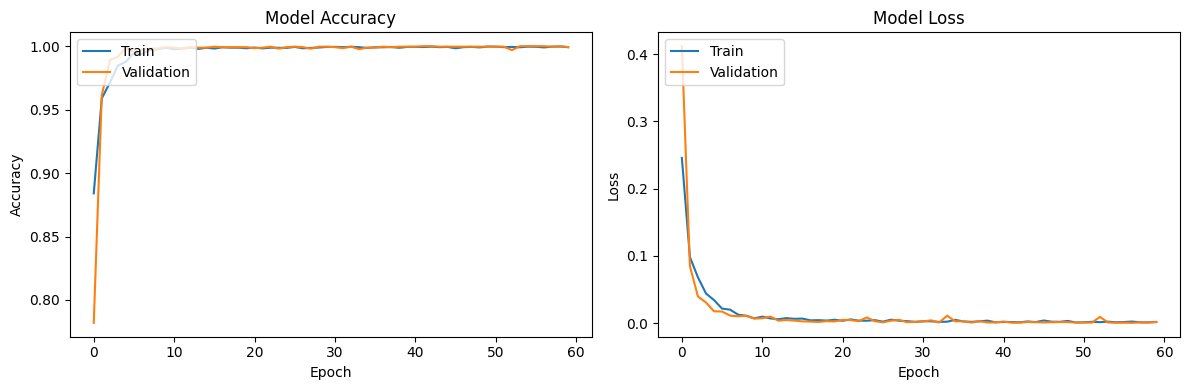

In [ ]:
import matplotlib.pyplot as plt

# Assuming `history` is the variable storing the history of the training process
def plot_training_history(history_r):
    # Plotting training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history_r.history['accuracy'])
    plt.plot(history_r.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plotting training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history_r.history['loss'])
    plt.plot(history_r.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_history(history_r)

** Res-TSSDNet**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

#ResNet-Style Module 1D
class RSM1D(layers.Layer):
    def __init__(self, channels_in, channels_out):
        super(RSM1D, self).__init__()
        self.conv1 = layers.Conv1D(filters=channels_out, kernel_size=3, padding='same', use_bias=False)
        self.conv2 = layers.Conv1D(filters=channels_out, kernel_size=3, padding='same', use_bias=False)
        self.conv3 = layers.Conv1D(filters=channels_out, kernel_size=3, padding='same', use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()
        self.bn3 = layers.BatchNormalization()
        self.nin = layers.Conv1D(filters=channels_out, kernel_size=1, use_bias=False)

    def call(self, x):
        y = tf.nn.relu(self.bn1(self.conv1(x)))
        y = tf.nn.relu(self.bn2(self.conv2(y)))
        y = self.conv3(y)
        x = self.nin(x)
        x = tf.nn.relu(self.bn3(x + y))
        return x

#Res-TSSDNet
#class SSDNet1D(models.Model):
    #def __init__(self):
        # super(SSDNet1D, self).__init__()
        # self.conv1 = layers.Conv1D(filters=16, kernel_size=7, padding='same', use_bias=False)
        # self.bn1 = layers.BatchNormalization()
        # self.RSM1 = RSM1D(16, 32)
        # self.RSM2 = RSM1D(32, 64)
        # self.RSM3 = RSM1D(64, 128)
        # self.RSM4 = RSM1D(128, 128)
        # self.fc1 = layers.Dense(64)
        # self.fc2 = layers.Dense(32)
        # self.out = layers.Dense(2)

    # def call(self, x):
    #     x = tf.nn.relu(self.bn1(self.conv1(x)))
    #     x = tf.nn.max_pool1d(x, pool_size=4, strides=4, padding='same')
    #     #stacked ResNet-Style Modules
    #     x = self.RSM1(x)
    #     x = tf.nn.max_pool1d(x, pool_size=4, strides=4, padding='same')
    #     x = self.RSM2(x)
    #     x = tf.nn.max_pool1d(x, pool_size=4, strides=4, padding='same')
    #     x = self.RSM3(x)
    #     x = tf.nn.max_pool1d(x, pool_size=4, strides=4, padding='same')
    #     x = self.RSM4(x)
    #     x = tf.nn.max_pool1d(x, pool_size=375, strides=375, padding='same')
    #     x = layers.Flatten()(x)
    #     x = tf.nn.relu(self.fc1(x))
    #     x = tf.nn.relu(self.fc2(x))
    #     x = self.out(x)
    #     return x

#Res-TSSDNet
def create_ssdnet1d(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(filters=16, kernel_size=7, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    #x = tf.nn.relu(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)

    # Stacked ResNet-Style Modules
    x = RSM1D(16, 32)(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    x = RSM1D(32, 64)(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    x = RSM1D(64, 128)(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    x = RSM1D(128, 128)(x)
    x = layers.GlobalMaxPooling1D()(x)

    x = layers.Flatten()(x)
    #x = tf.nn.relu(layers.Dense(64)(x))
    x = layers.Dense(64)(x)
    x = layers.ReLU()(x)
    #x = tf.nn.relu(layers.Dense(32)(x))
    x = layers.Dense(32)(x)
    x = layers.ReLU()(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)  # For binary classification

    model = models.Model(inputs, outputs)
    return model


In [ ]:
# Create the model with the specified input shape
model_ssdnet1d = create_ssdnet1d(Config.input_shape)
model_ssdnet1d.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=Config.learning_rate),loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model_ssdnet1d.summary()

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 10000, 1)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_96 (Conv1D)                   │ (None, 10000, 16)           │             112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_92               │ (None, 10000, 16)           │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_7 (ReLU)                       │ (None, 10000, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_19 (MaxPooling1D)      │ (None, 2500, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rsm1d (RSM1D)                        │ (None, 2500, 32)            │           8,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_20 (MaxPooling1D)      │ (None, 625, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rsm1d_1 (RSM1D)                      │ (None, 625, 64)             │          33,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_21 (MaxPooling1D)      │ (None, 157, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rsm1d_2 (RSM1D)                      │ (None, 157, 128)            │         132,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_22 (MaxPooling1D)      │ (None, 40, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rsm1d_3 (RSM1D)                      │ (None, 40, 128)             │         165,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_3               │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_8 (ReLU)                       │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_9 (ReLU)                       │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 350,641 (1.34 MB)

 Trainable params: 348,497 (1.33 MB)

 Non-trainable params: 2,144 (8.38 KB)

In [ ]:
# Train the model
checkpoint_s = ModelCheckpoint(Config.best_model_path_s, monitor='val_accuracy', save_best_only=True, mode='max')
history_s = model_ssdnet1d.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2, callbacks=[checkpoint_s])

Epoch 1/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.7381 - loss: 0.4754 - val_accuracy: 0.7143 - val_loss: 0.5899
Epoch 2/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8943 - loss: 0.2227 - val_accuracy: 0.9047 - val_loss: 0.2127
Epoch 3/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9210 - loss: 0.1646 - val_accuracy: 0.9379 - val_loss: 0.1475
Epoch 4/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9362 - loss: 0.1405 - val_accuracy: 0.9441 - val_loss: 0.1161
Epoch 5/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9419 - loss: 0.1245 - val_accuracy: 0.9492 - val_loss: 0.1088
Epoch 6/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9561 - loss: 0.0992 - val_accuracy: 0.9429 - val_loss: 0.1189
Epoch 7/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9563 - loss: 0.1001 - val_accuracy: 0.9488 - val_loss: 0.1145
Epoch 8/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9633 - loss: 0.0819 - val_acc

In [ ]:
# Evaluate the model- for K_NC=2.1, K_C=2.3
model_ssdnet1d.load_weights(Config.best_model_path_s)
loss, accuracy = model_ssdnet1d.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9972 - loss: 0.0091
Test loss: 0.007565373554825783
Test accuracy: 0.9978117942810059


In [ ]:
#Add
# Evaluate the model- for K_NC=2.0, K_C=2.4
model_ssdnet1d.load_weights(Config.best_model_path_s)
loss, accuracy = model_ssdnet1d.evaluate(X_test_T, y_test_T)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9802 - loss: 0.0681
Test loss: 0.18103013932704926
Test accuracy: 0.9497185945510864


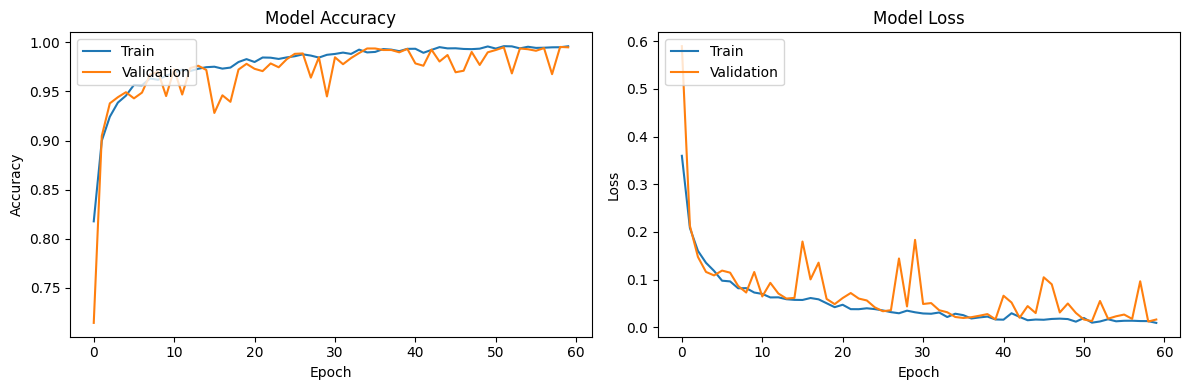

In [ ]:
import matplotlib.pyplot as plt

# Assuming `history` is the variable storing the history of the training process
def plot_training_history(history_s):
    # Plotting training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history_s.history['accuracy'])
    plt.plot(history_s.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plotting training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history_s.history['loss'])
    plt.plot(history_s.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_history(history_s)

**Inception style, Inc-TSSDNet**


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Dilated Convolution Module 1D (equivalent to ISM1D in the previous code)
class DilatedConvModule(layers.Layer):
    def __init__(self, channels_in, channels_out1, channels_out2, channels_out3, channels_out4):
        super(DilatedConvModule, self).__init__()
        self.conv1 = layers.Conv1D(filters=channels_out1, kernel_size=3, padding='same', dilation_rate=1, use_bias=False)
        self.conv2 = layers.Conv1D(filters=channels_out2, kernel_size=3, padding='same', dilation_rate=2, use_bias=False)
        self.conv3 = layers.Conv1D(filters=channels_out3, kernel_size=3, padding='same', dilation_rate=4, use_bias=False)
        self.conv4 = layers.Conv1D(filters=channels_out4, kernel_size=3, padding='same', dilation_rate=8, use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()
        self.bn3 = layers.BatchNormalization()
        self.bn4 = layers.BatchNormalization()

    def call(self, x):
        y1 = tf.nn.relu(self.bn1(self.conv1(x)))
        y2 = tf.nn.relu(self.bn2(self.conv2(x)))
        y3 = tf.nn.relu(self.bn3(self.conv3(x)))
        y4 = tf.nn.relu(self.bn4(self.conv4(x)))
        y = tf.concat([y1, y2, y3, y4], axis=-1)
        return y

# Inc-TSSDNet
def create_inc_tssdnet(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(filters=16, kernel_size=7, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    #x = tf.nn.relu(x)
    #x = layers.Dense(64)(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)

    # Stacked Dilated Convolution Modules
    # x = DilatedConvModule(16, 32)(x)
    # x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    # x = DilatedConvModule(32, 64)(x)
    # x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    # x = DilatedConvModule(64, 128)(x)
    # x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    # x = DilatedConvModule(128, 128)(x)
    # x = layers.GlobalMaxPooling1D()(x)

    # Stacked Dilated Convolution Modules
    x = DilatedConvModule(16, 16, 32, 64, 128)(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    x = DilatedConvModule(240, 32, 64, 128, 256)(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    x = DilatedConvModule(480, 64, 128, 256, 512)(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    x = DilatedConvModule(960, 128, 256, 512, 1024)(x)
    x = layers.GlobalMaxPooling1D()(x)

    x = layers.Flatten()(x)
    #x = tf.nn.relu(layers.Dense(64)(x))
    x = layers.Dense(64)(x)
    x = layers.ReLU()(x)
    #x = tf.nn.relu(layers.Dense(32)(x))
    x = layers.Dense(32)(x)
    x = layers.ReLU()(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)  # For binary classification

    model = models.Model(inputs, outputs)
    return model


In [ ]:
# Create the model with the specified input shape
model_Incnet = create_inc_tssdnet(Config.input_shape)
model_Incnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=Config.learning_rate),loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model_Incnet.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 10000, 1)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_53 (Conv1D)                   │ (None, 10000, 16)           │             112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_51               │ (None, 10000, 16)           │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 10000, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 2500, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dilated_conv_module_8                │ (None, 2500, 240)           │          12,480 │
│ (DilatedConvModule)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_9 (MaxPooling1D)       │ (None, 625, 240)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dilated_conv_module_9                │ (None, 625, 480)            │         347,520 │
│ (DilatedConvModule)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_10 (MaxPooling1D)      │ (None, 157, 480)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dilated_conv_module_10               │ (None, 157, 960)            │       1,386,240 │
│ (DilatedConvModule)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_11 (MaxPooling1D)      │ (None, 40, 960)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dilated_conv_module_11               │ (None, 40, 1920)            │       5,537,280 │
│ (DilatedConvModule)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_2               │ (None, 1920)                │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1920)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │         122,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_22 (LeakyReLU)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_23 (LeakyReLU)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 7,408,753 (28.26 MB)

 Trainable params: 7,401,521 (28.23 MB)

 Non-trainable params: 7,232 (28.25 KB)

In [ ]:
# Train the model
checkpoint_i = ModelCheckpoint(Config.best_model_path_i, monitor='val_accuracy', save_best_only=True, mode='max')
history_i = model_Incnet.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2, callbacks=[checkpoint_i])

Epoch 1/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 60s 129ms/step - accuracy: 0.8248 - loss: 0.3383 - val_accuracy: 0.7405 - val_loss: 0.4843
Epoch 2/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 28s 88ms/step - accuracy: 0.9068 - loss: 0.1742 - val_accuracy: 0.9168 - val_loss: 0.2041
Epoch 3/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 29s 91ms/step - accuracy: 0.9293 - loss: 0.1410 - val_accuracy: 0.9242 - val_loss: 0.1426
Epoch 4/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 29s 90ms/step - accuracy: 0.9355 - loss: 0.1260 - val_accuracy: 0.9242 - val_loss: 0.1634
Epoch 5/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 29s 90ms/step - accuracy: 0.9484 - loss: 0.1109 - val_accuracy: 0.9480 - val_loss: 0.1127
Epoch 6/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 28s 88ms/step - accuracy: 0.9464 - loss: 0.1050 - val_accuracy: 0.9254 - val_loss: 0.1482
Epoch 7/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 28s 88ms/step - accuracy: 0.9485 - loss: 0.1023 - val_accuracy: 0.9469 - val_loss: 0.1193
Epoch 8/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 28s 88ms/step - accuracy: 0.9526 - loss: 0.0938 -

In [ ]:
# Evaluate the model- for K_NC=2.1, K_C=2.3
model_Incnet.load_weights(Config.best_model_path_i)
loss, accuracy = model_Incnet.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9730 - loss: 0.0770
Test loss: 0.07267561554908752
Test accuracy: 0.9746795892715454


In [ ]:
#Add
# Evaluate the model- for K_NC=2.0, K_C=2.4
model_Incnet.load_weights(Config.best_model_path_i)
loss, accuracy = model_Incnet.evaluate(X_test_T, y_test_T)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9442 - loss: 0.1450
Test loss: 0.23509445786476135
Test accuracy: 0.9405253529548645


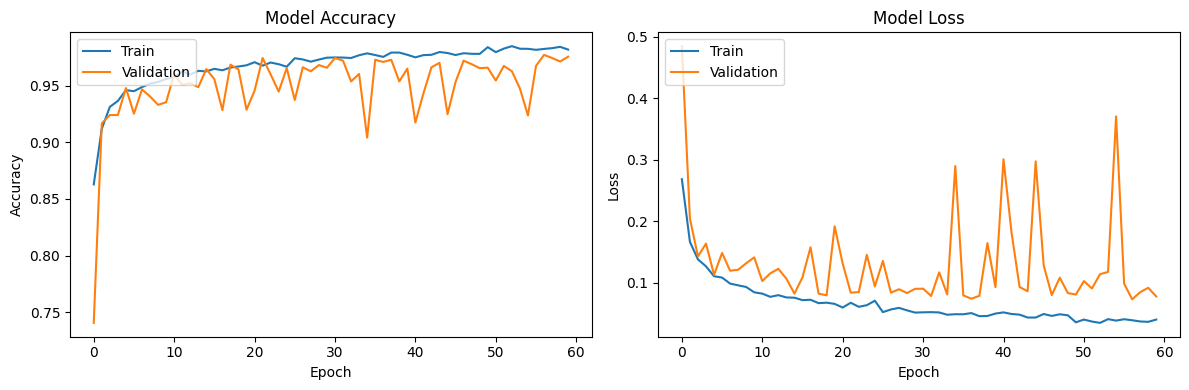

In [ ]:
import matplotlib.pyplot as plt

# Assuming `history` is the variable storing the history of the training process
def plot_training_history(history_i):
    # Plotting training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history_i.history['accuracy'])
    plt.plot(history_i.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plotting training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history_i.history['loss'])
    plt.plot(history_i.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_history(history_i)

In [ ]:
#Add
import matplotlib.pyplot as plt

# Assuming `history` is the variable storing the history of the training process
def plot_training_history(history_i):
    # Plotting training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history_i.history['accuracy'])
    plt.plot(history_i.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plotting training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history_i.history['loss'])
    plt.plot(history_i.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_history(history_i)

**Mod-IncNet**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks

# Dilated Convolution Module 1D (equivalent to ISM1D in the previous code)
class DilatedConvModule(layers.Layer):
    def __init__(self, channels_in, channels_out1, channels_out2, channels_out3, channels_out4):
        super(DilatedConvModule, self).__init__()
        self.conv1 = layers.Conv1D(filters=channels_out1, kernel_size=3, padding='same', dilation_rate=1, use_bias=False)
        self.conv2 = layers.Conv1D(filters=channels_out2, kernel_size=3, padding='same', dilation_rate=2, use_bias=False)
        self.conv3 = layers.Conv1D(filters=channels_out3, kernel_size=3, padding='same', dilation_rate=4, use_bias=False)
        self.conv4 = layers.Conv1D(filters=channels_out4, kernel_size=3, padding='same', dilation_rate=8, use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()
        self.bn3 = layers.BatchNormalization()
        self.bn4 = layers.BatchNormalization()

    def call(self, x):
        y1 = tf.nn.relu(self.bn1(self.conv1(x)))
        y2 = tf.nn.relu(self.bn2(self.conv2(x)))
        y3 = tf.nn.relu(self.bn3(self.conv3(x)))
        y4 = tf.nn.relu(self.bn4(self.conv4(x)))
        y = tf.concat([y1, y2, y3, y4], axis=-1)
        return y

# Residual Block
def residual_block(l, increase_dim=False, first=False, keep_filter=False, strides=None, r_value=None):
    input_num_filters = tf.keras.backend.int_shape(l)[-1]

    if increase_dim:
        first_stride = strides
        out_num_filters = input_num_filters * 2 if not keep_filter else input_num_filters
    else:
        first_stride = 1
        out_num_filters = input_num_filters

    if not first:
        bn_pre_conv = layers.BatchNormalization()(l)
        bn_pre_relu = layers.LeakyReLU()(bn_pre_conv)
    else:
        bn_pre_relu = l

    conv_1 = layers.LeakyReLU()(
        layers.BatchNormalization()(
            layers.Conv1D(filters=out_num_filters, kernel_size=3, strides=first_stride, padding='same', kernel_regularizer=regularizers.l2(r_value))(bn_pre_relu)
        )
    )

    conv_2 = layers.Conv1D(filters=out_num_filters, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(r_value))(conv_1)

    if increase_dim:
        projection = layers.Conv1D(filters=out_num_filters, kernel_size=1, strides=first_stride, padding='same', use_bias=False, kernel_regularizer=regularizers.l2(r_value))(l)
        block = layers.Add()([conv_2, projection])
    else:
        block = layers.Add()([conv_2, l])

    return block

# Inc-TSSDNet with Residual Blocks, Stacked Conv Modules, Dropout, and Early Stopping
def create_inc_tssdnet_with_residual_and_conv_modules(input_shape, r_value=0.01, dropout_rate=0.5):
    inputs = layers.Input(shape=input_shape)

    # Initial Conv Layer
    x = layers.Conv1D(filters=16, kernel_size=7, padding='same', use_bias=False, kernel_regularizer=regularizers.l2(r_value))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)

    # Stacked Dilated Convolution Modules
    x = DilatedConvModule(16, 16, 32, 64, 128)(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    x = DilatedConvModule(240, 32, 64, 128, 256)(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    x = DilatedConvModule(480, 64, 128, 256, 512)(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    x = DilatedConvModule(960, 128, 256, 512, 1024)(x)

    # Global MaxPooling
    x = layers.GlobalMaxPooling1D()(x)

    # Residual Blocks
    x = layers.Reshape((1, -1))(x)  # Adjusting to match residual block input shape

    x = residual_block(x, first=True, r_value=r_value)
    for _ in range(1, 2):
        x = residual_block(x, r_value=r_value)

    x = residual_block(x, increase_dim=True, strides=2, r_value=r_value)
    for _ in range(1, 2):
        x = residual_block(x, r_value=r_value)

    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    # Final Layers with Dropout
    x = layers.Flatten()(x)
    x = layers.Dropout(dropout_rate)(x)
    #x = tf.nn.relu(layers.Dense(64)(x))
    x = layers.Dense(64)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(dropout_rate)(x)
    #x = tf.nn.relu(layers.Dense(32)(x))
    x = layers.Dense(32)(x)
    x = layers.LeakyReLU()(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)  # For binary classification

    model = models.Model(inputs, outputs)
    return model

In [ ]:
# Create the model with the specified input shape
model_Incnet_m = create_inc_tssdnet_with_residual_and_conv_modules(Config.input_shape, r_value=0.01, dropout_rate=0.5)
model_Incnet_m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=Config.learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model_Incnet_m.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 10000, 1)       │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_26 (Conv1D)        │ (None, 10000, 16)      │            112 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_25    │ (None, 10000, 16)      │             64 │ conv1d_26[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_11            │ (None, 10000, 16)      │              0 │ batch_normalization_2… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_4           │ (None, 2500, 16)       │              0 │ leaky_re_lu_11[0][0]   │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dilated_conv_module_4     │ (None, 2500, 240)      │         12,480 │ max_pooling1d_4[0][0]  │
│ (DilatedConvModule)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_5           │ (None, 625, 240)       │              0 │ dilated_conv_module_4… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dilated_conv_module_5     │ (None, 625, 480)       │        347,520 │ max_pooling1d_5[0][0]  │
│ (DilatedConvModule)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_6           │ (None, 157, 480)       │              0 │ dilated_conv_module_5… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dilated_conv_module_6     │ (None, 157, 960)       │      1,386,240 │ max_pooling1d_6[0][0]  │
│ (DilatedConvModule)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_7           │ (None, 40, 960)        │              0 │ dilated_conv_module_6… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dilated_conv_module_7     │ (None, 40, 1920)       │      5,537,280 │ max_pooling1d_7[0][0]  │
│ (DilatedConvModule)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_1    │ (None, 1920)           │              0 │ dilated_conv_module_7… │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)  

 Total params: 214,085,233 (816.67 MB)

 Trainable params: 214,031,921 (816.47 MB)

 Non-trainable params: 53,312 (208.25 KB)

In [ ]:
# Train the model
checkpoint_m = ModelCheckpoint(Config.best_model_path_m, monitor='val_accuracy', save_best_only=True, mode='max')
history_m = model_Incnet_m.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2, callbacks=[checkpoint_m])

Epoch 1/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 141s 349ms/step - accuracy: 0.8046 - loss: 137.7917 - val_accuracy: 0.7898 - val_loss: 24.2601
Epoch 2/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 93s 290ms/step - accuracy: 0.8816 - loss: 16.1612 - val_accuracy: 0.9066 - val_loss: 3.6334
Epoch 3/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 79s 246ms/step - accuracy: 0.9054 - loss: 2.5097 - val_accuracy: 0.8980 - val_loss: 0.7624
Epoch 4/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 95s 296ms/step - accuracy: 0.9199 - loss: 0.5815 - val_accuracy: 0.9261 - val_loss: 0.3450
Epoch 5/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 79s 247ms/step - accuracy: 0.9209 - loss: 0.3380 - val_accuracy: 0.8906 - val_loss: 0.4864
Epoch 6/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 94s 295ms/step - accuracy: 0.9226 - loss: 0.3523 - val_accuracy: 0.9347 - val_loss: 0.3041
Epoch 7/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 80s 250ms/step - accuracy: 0.9279 - loss: 0.3150 - val_accuracy: 0.9308 - val_loss: 0.2877
Epoch 8/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 96s 299ms/step - accuracy: 0.9384 - lo

In [ ]:
# Evaluate the model- for K_NC=2.1, K_C=2.3
model_Incnet_m.load_weights(Config.best_model_path_m)
loss, accuracy = model_Incnet_m.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.9754 - loss: 0.2261
Test loss: 0.22214552760124207
Test accuracy: 0.9778055548667908


In [ ]:
#Add
# Evaluate the model- for K_NC=2.0, K_C=2.4
model_Incnet_m.load_weights(Config.best_model_path_m)
loss, accuracy = model_Incnet_m.evaluate(X_test_T, y_test_T)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.9482 - loss: 0.2851
Test loss: 0.4276341199874878
Test accuracy: 0.9159474968910217


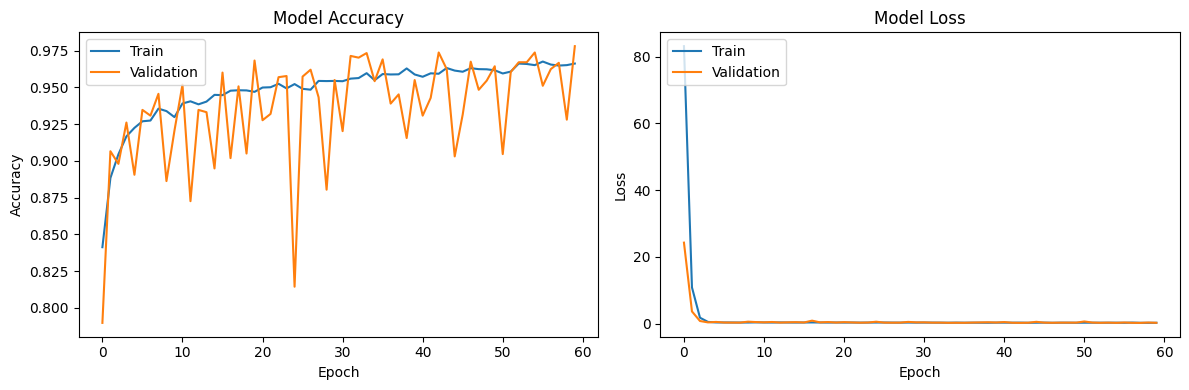

In [ ]:
import matplotlib.pyplot as plt

# Assuming `history` is the variable storing the history of the training process
def plot_training_history(history_m):
    # Plotting training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history_m.history['accuracy'])
    plt.plot(history_m.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plotting training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history_m.history['loss'])
    plt.plot(history_m.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_history(history_m)

**Mod-IncNet 2**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks

# Dilated Convolution Module 1D
class DilatedConvModule(layers.Layer):
    def __init__(self, channels_in, channels_out1, channels_out2, channels_out3, channels_out4, dropout_rate=0.3):
        super(DilatedConvModule, self).__init__()
        self.conv1 = layers.Conv1D(filters=channels_out1, kernel_size=3, padding='same', dilation_rate=1, use_bias=False)
        self.conv2 = layers.Conv1D(filters=channels_out2, kernel_size=3, padding='same', dilation_rate=2, use_bias=False)
        self.conv3 = layers.Conv1D(filters=channels_out3, kernel_size=3, padding='same', dilation_rate=4, use_bias=False)
        self.conv4 = layers.Conv1D(filters=channels_out4, kernel_size=3, padding='same', dilation_rate=8, use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()
        self.bn3 = layers.BatchNormalization()
        self.bn4 = layers.BatchNormalization()
        self.dropout = layers.Dropout(dropout_rate)

    def call(self, x, training=False):
        y1 = tf.nn.relu(self.bn1(self.conv1(x), training=training))
        y2 = tf.nn.relu(self.bn2(self.conv2(x), training=training))
        y3 = tf.nn.relu(self.bn3(self.conv3(x), training=training))
        y4 = tf.nn.relu(self.bn4(self.conv4(x), training=training))
        y = tf.concat([y1, y2, y3, y4], axis=-1)
        y = self.dropout(y, training=training)
        return y

# Residual Block
def residual_block(l, increase_dim=False, first=False, keep_filter=False, strides=None, r_value=None, dropout_rate=0.3):
    input_num_filters = tf.keras.backend.int_shape(l)[-1]

    if increase_dim:
        first_stride = strides
        out_num_filters = input_num_filters * 2 if not keep_filter else input_num_filters
    else:
        first_stride = 1
        out_num_filters = input_num_filters

    if not first:
        bn_pre_conv = layers.BatchNormalization()(l)
        bn_pre_relu = layers.LeakyReLU()(bn_pre_conv)
    else:
        bn_pre_relu = l

    conv_1 = layers.LeakyReLU()(
        layers.BatchNormalization()(
            layers.Conv1D(filters=out_num_filters, kernel_size=3, strides=first_stride, padding='same', kernel_regularizer=regularizers.l2(r_value))(bn_pre_relu)
        )
    )

    conv_2 = layers.Conv1D(filters=out_num_filters, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(r_value))(conv_1)

    if increase_dim:
        projection = layers.Conv1D(filters=out_num_filters, kernel_size=1, strides=first_stride, padding='same', use_bias=False, kernel_regularizer=regularizers.l2(r_value))(l)
        block = layers.Add()([conv_2, projection])
    else:
        block = layers.Add()([conv_2, l])

    block = layers.Dropout(dropout_rate)(block)
    return block

# Create the model with residual blocks and dilated conv modules
def create_inc_tssdnet_with_residual_and_conv_modules(input_shape, r_value=0.01, dropout_rate=0.5):
    inputs = layers.Input(shape=input_shape)

    # Initial Conv Layer
    x = layers.Conv1D(filters=16, kernel_size=7, padding='same', use_bias=False, kernel_regularizer=regularizers.l2(r_value))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)

    # Stacked Dilated Convolution Modules
    x = DilatedConvModule(16, 16, 32, 64, 128)(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    x = DilatedConvModule(240, 32, 64, 128, 256)(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    x = DilatedConvModule(480, 64, 128, 256, 512)(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    x = DilatedConvModule(960, 128, 256, 512, 1024)(x)

    # Global MaxPooling
    x = layers.GlobalMaxPooling1D()(x)

    # Residual Blocks
    x = layers.Reshape((1, -1))(x)  # Reshape for 1D Convolution
    x = residual_block(x, first=True, r_value=r_value)
    for _ in range(1, 2):
        x = residual_block(x, r_value=r_value)

    x = residual_block(x, increase_dim=True, strides=2, r_value=r_value)
    for _ in range(1, 2):
        x = residual_block(x, r_value=r_value)

    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    # Final Layers with Dropout
    x = layers.Flatten()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(64, kernel_regularizer=regularizers.l2(r_value))(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(32, kernel_regularizer=regularizers.l2(r_value))(x)
    x = layers.LeakyReLU()(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)  # For binary classification

    model = models.Model(inputs, outputs)
    return model


In [ ]:
# Create the model with the specified input shape
model_Incnet_m2 = create_inc_tssdnet_with_residual_and_conv_modules(Config.input_shape, r_value=0.01, dropout_rate=0.5)
model_Incnet_m2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=Config.learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model_Incnet_m2.summary()

# Learning Rate Scheduler
lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# Early Stopping
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 10000, 1)       │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 10000, 16)      │            112 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 10000, 16)      │             64 │ conv1d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 10000, 16)      │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 2500, 16)       │              0 │ leaky_re_lu[0][0]      │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dilated_conv_module       │ (None, 2500, 240)      │         12,480 │ max_pooling1d[0][0]    │
│ (DilatedConvModule)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_1           │ (None, 625, 240)       │              0 │ dilated_conv_module[0… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dilated_conv_module_1     │ (None, 625, 480)       │        347,520 │ max_pooling1d_1[0][0]  │
│ (DilatedConvModule)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_2           │ (None, 157, 480)       │              0 │ dilated_conv_module_1… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dilated_conv_module_2     │ (None, 157, 960)       │      1,386,240 │ max_pooling1d_2[0][0]  │
│ (DilatedConvModule)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_3           │ (None, 40, 960)        │              0 │ dilated_conv_module_2… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dilated_conv_module_3     │ (None, 40, 1920)       │      5,537,280 │ max_pooling1d_3[0][0]  │
│ (DilatedConvModule)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 1920)           │              0 │ dilated_conv_module_3… │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1920)        │              0 │ global_max_pooling1d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_17 (Conv1D)   

 Total params: 214,085,233 (816.67 MB)

 Trainable params: 214,031,921 (816.47 MB)

 Non-trainable params: 53,312 (208.25 KB)

In [ ]:
# Model Checkpoint
checkpoint_m2 = callbacks.ModelCheckpoint(Config.best_model_path_m2, monitor='val_accuracy', save_best_only=True, mode='max')
history_m2 = model_Incnet_m2.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2, callbacks=[checkpoint_m2, lr_scheduler, early_stopping])

Epoch 1/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 182s 412ms/step - accuracy: 0.7118 - loss: 131.8493 - val_accuracy: 0.5076 - val_loss: 21.9461 - learning_rate: 1.0000e-04
Epoch 2/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 95s 297ms/step - accuracy: 0.8737 - loss: 16.1777 - val_accuracy: 0.7362 - val_loss: 7.2875 - learning_rate: 1.0000e-04
Epoch 3/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 96s 299ms/step - accuracy: 0.8900 - loss: 5.6635 - val_accuracy: 0.7503 - val_loss: 3.2951 - learning_rate: 1.0000e-04
Epoch 4/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 81s 252ms/step - accuracy: 0.9107 - loss: 2.5293 - val_accuracy: 0.7335 - val_loss: 1.9097 - learning_rate: 1.0000e-04
Epoch 5/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 81s 253ms/step - accuracy: 0.9114 - loss: 1.3827 - val_accuracy: 0.6999 - val_loss: 1.3717 - learning_rate: 1.0000e-04
Epoch 6/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 81s 253ms/step - accuracy: 0.9147 - loss: 0.9489 - val_accuracy: 0.5869 - val_loss: 1.1067 - learning_rate: 1.0000e-04
Epoch 7/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 8

In [ ]:
# Evaluate the model
model_Incnet_m2.load_weights(Config.best_model_path_m2)
loss, accuracy = model_Incnet_m2.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9598 - loss: 0.6034
Test loss: 0.5970734357833862
Test accuracy: 0.961237907409668


In [ ]:
#Add
# Evaluate the model- for K_NC=2.0, K_C=2.4
model_Incnet_m2.load_weights(Config.best_model_path_m2)
loss, accuracy = model_Incnet_m2.evaluate(X_test_T, y_test_T)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.9005 - loss: 0.5731
Test loss: 0.7205137610435486
Test accuracy: 0.748092532157898


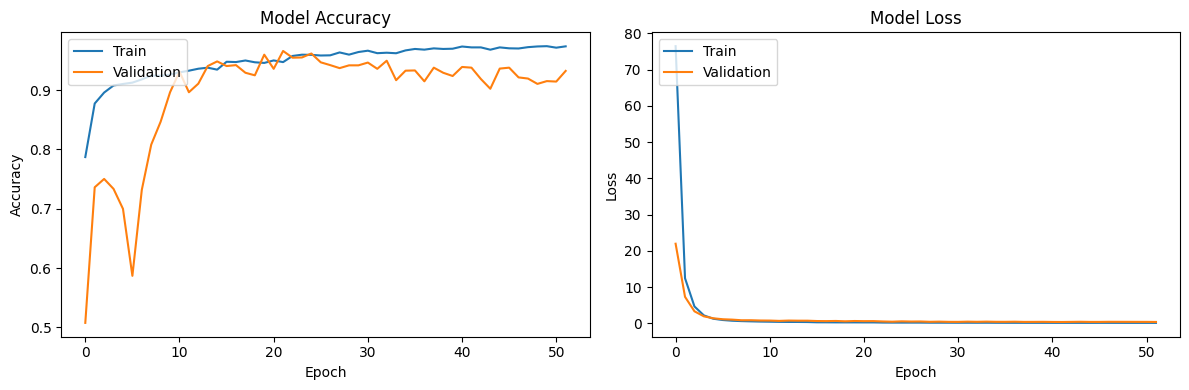

In [ ]:
import matplotlib.pyplot as plt

# Assuming `history` is the variable storing the history of the training process
def plot_training_history(history_m2):
    # Plotting training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history_m2.history['accuracy'])
    plt.plot(history_m2.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plotting training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history_m2.history['loss'])
    plt.plot(history_m2.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_history(history_m2)

**Mod-ResTSSDNet**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks

# ResNet-Style Module 1D
class RSM1D(layers.Layer):
    def __init__(self, channels_in, channels_out):
        super(RSM1D, self).__init__()
        self.conv1 = layers.Conv1D(filters=channels_out, kernel_size=3, padding='same', use_bias=False)
        self.conv2 = layers.Conv1D(filters=channels_out, kernel_size=3, padding='same', use_bias=False)
        self.conv3 = layers.Conv1D(filters=channels_out, kernel_size=3, padding='same', use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()
        self.bn3 = layers.BatchNormalization()
        self.nin = layers.Conv1D(filters=channels_out, kernel_size=1, use_bias=False)

    def call(self, x):
        y = tf.nn.relu(self.bn1(self.conv1(x)))
        y = tf.nn.relu(self.bn2(self.conv2(y)))
        y = self.conv3(y)
        x = self.nin(x)
        x = tf.nn.relu(self.bn3(x + y))
        return x

# Residual Block
def residual_block(l, increase_dim=False, first=False, keep_filter=False, strides=None, r_value=None, dropout_rate=0.3):
    input_num_filters = tf.keras.backend.int_shape(l)[-1]

    if increase_dim:
        first_stride = strides
        out_num_filters = input_num_filters * 2 if not keep_filter else input_num_filters
    else:
        first_stride = 1
        out_num_filters = input_num_filters

    if not first:
        bn_pre_conv = layers.BatchNormalization()(l)
        bn_pre_relu = layers.LeakyReLU()(bn_pre_conv)
    else:
        bn_pre_relu = l

    conv_1 = layers.LeakyReLU()(
        layers.BatchNormalization()(
            layers.Conv1D(filters=out_num_filters, kernel_size=3, strides=first_stride, padding='same', kernel_regularizer=regularizers.l2(r_value))(bn_pre_relu)
        )
    )

    conv_2 = layers.Conv1D(filters=out_num_filters, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(r_value))(conv_1)

    if increase_dim:
        projection = layers.Conv1D(filters=out_num_filters, kernel_size=1, strides=first_stride, padding='same', use_bias=False, kernel_regularizer=regularizers.l2(r_value))(l)
        block = layers.Add()([conv_2, projection])
    else:
        block = layers.Add()([conv_2, l])

    block = layers.Dropout(dropout_rate)(block)
    return block


# Res-TSSDNet
def create_ssdnet1d_with_residual_and_conv_modules(input_shape, r_value=0.01, dropout_rate=0.5):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(filters=16, kernel_size=7, padding='same', use_bias=False,  kernel_regularizer=regularizers.l2(r_value))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)

    # Stacked ResNet-Style Modules
    x = RSM1D(16, 32)(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    x = RSM1D(32, 64)(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    x = RSM1D(64, 128)(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    x = RSM1D(128, 128)(x)
    x = layers.GlobalMaxPooling1D()(x)

     # Residual Blocks
    x = layers.Reshape((1, -1))(x)  # Reshape for 1D Convolution
    x = residual_block(x, first=True, r_value=r_value)
    for _ in range(1, 3):
        x = residual_block(x, r_value=r_value)

    x = residual_block(x, increase_dim=True, strides=2, r_value=r_value)
    for _ in range(1, 3):
        x = residual_block(x, r_value=r_value)

    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)


    x = layers.Flatten()(x)
    x = layers.Dense(64, kernel_regularizer=regularizers.l2(r_value))(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(32, kernel_regularizer=regularizers.l2(r_value))(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)

    # Output layer for binary classification
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    return model

In [ ]:
# Create the model with the specified input shape
model_Restssd = create_ssdnet1d_with_residual_and_conv_modules(Config.input_shape, r_value=0.01, dropout_rate=0.5)
model_Restssd.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=Config.learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model_Restssd.summary()

# Learning Rate Scheduler
lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# Early Stopping
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 10000, 1)       │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 10000, 16)      │            112 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 10000, 16)      │             64 │ conv1d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 10000, 16)      │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 2500, 16)       │              0 │ re_lu[0][0]            │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rsm1d (RSM1D)             │ (None, 2500, 32)       │          8,576 │ max_pooling1d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_1           │ (None, 625, 32)        │              0 │ rsm1d[0][0]            │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rsm1d_1 (RSM1D)           │ (None, 625, 64)        │         33,536 │ max_pooling1d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_2           │ (None, 157, 64)        │              0 │ rsm1d_1[0][0]          │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rsm1d_2 (RSM1D)           │ (None, 157, 128)       │        132,608 │ max_pooling1d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_3           │ (None, 40, 128)        │              0 │ rsm1d_2[0][0]          │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rsm1d_3 (RSM1D)           │ (None, 40, 128)        │        165,376 │ max_pooling1d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 128)            │              0 │ rsm1d_3[0][0]          │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 128)         │              0 │ global_max_pooling1d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_17 (Conv1D)        │ (None, 1, 128)         │         49,280 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 1, 128)         │            512 │ conv1d_17[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 1,779,377 (6.79 MB)

 Trainable params: 1,772,625 (6.76 MB)

 Non-trainable params: 6,752 (26.38 KB)

In [ ]:
# Model Checkpoint
checkpoint_rtssd = callbacks.ModelCheckpoint(Config.best_model_path_rtssd, monitor='val_accuracy', save_best_only=True, mode='max')
history_rtssd = model_Restssd.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2, callbacks=[checkpoint_rtssd, lr_scheduler, early_stopping])

Epoch 1/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 59s 79ms/step - accuracy: 0.5083 - loss: 21.3759 - val_accuracy: 0.4924 - val_loss: 11.3644 - learning_rate: 1.0000e-04
Epoch 2/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5101 - loss: 9.7874 - val_accuracy: 0.6647 - val_loss: 6.2888 - learning_rate: 1.0000e-04
Epoch 3/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.5982 - loss: 5.6570 - val_accuracy: 0.7722 - val_loss: 4.1263 - learning_rate: 1.0000e-04
Epoch 4/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.7497 - loss: 3.7899 - val_accuracy: 0.8484 - val_loss: 2.8921 - learning_rate: 1.0000e-04
Epoch 5/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.8605 - loss: 2.6814 - val_accuracy: 0.8742 - val_loss: 2.1305 - learning_rate: 1.0000e-04
Epoch 6/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9149 - loss: 1.9872 - val_accuracy: 0.9277 - val_loss: 1.6071 - learning_rate: 1.0000e-04
Epoch 7/60
320/320 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - 

In [ ]:
# Evaluate the model
model_Restssd.load_weights(Config.best_model_path_rtssd)
loss, accuracy = model_Restssd.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9947 - loss: 0.0485
Test loss: 0.04589634761214256
Test accuracy: 0.9965614080429077


In [ ]:
#Add
# Evaluate the model- for K_NC=2.0, K_C=2.4
model_Restssd.load_weights(Config.best_model_path_rtssd)
loss, accuracy = model_Restssd.evaluate(X_test_T, y_test_T)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9703 - loss: 0.1438
Test loss: 0.3569287061691284
Test accuracy: 0.9128830432891846


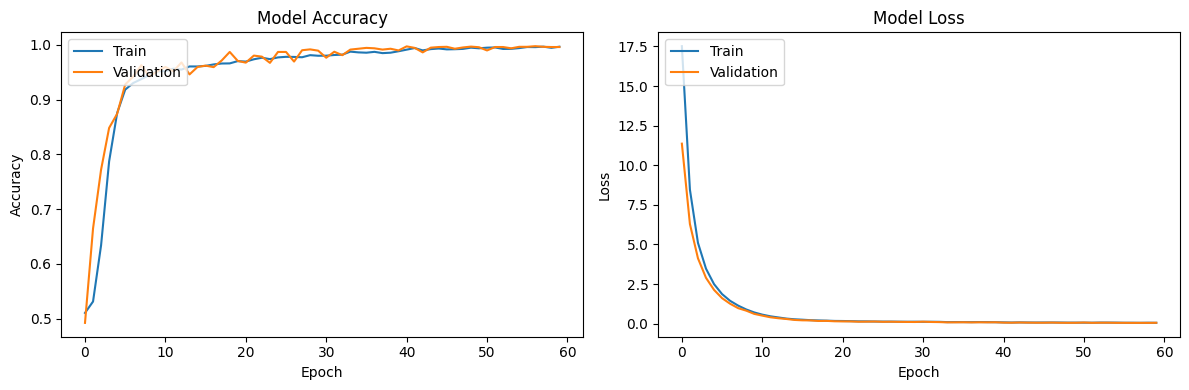

In [ ]:
import matplotlib.pyplot as plt

# Assuming `history` is the variable storing the history of the training process
def plot_training_history(history_rtssd):
    # Plotting training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history_rtssd.history['accuracy'])
    plt.plot(history_rtssd.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plotting training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history_rtssd.history['loss'])
    plt.plot(history_rtssd.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_history(history_rtssd)